## COMP5623M Assessment Coursework 1 - Image Classification [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Practice building, evaluating, and finetuning a convolutional neural network on an image dataset from development to testing. 
> 2. Gain a deeper understanding of feature maps and filters by visualizing some from a pre-trained network. 


### Setup and resources 

You must work using this provided template notebook.

Having a GPU will speed up the training process, especially for Question 1.3. See the provided document on Minerva about setting up a working environment for various ways to access a GPU.

Please implement the coursework using **Python and PyTorch**, and refer to the notebooks and exercises provided.

This coursework will use a subset of images from Tiny ImageNet, which is a subset of the ImageNet dataset [https://image-net.org/]. Our subset of Tiny ImageNet contains 30 different categories, we will refer to it as TinyImageNet30. The training set has 450 resized images (64x64 pixels) for each category (13,500 images in total). You can download the training and test set from the Kaggle website:

>[Private class Kaggle competition and data](https://www.kaggle.com/t/9b703e0d71824a658e186d5f69960e27)

To access the dataset, you will need an account on the Kaggle website. Even if you have an existing Kaggle account, please carefully adhere to these instructions, or we may not be able to locate your entries:

> 1. Use your **university email** to register a new account.
> 2. Set your **Kaggle account NAME** to your university username, for example, ``sc15jb``.

The class Kaggle competition also includes a blind test set, which will be used in Question 1 for evaluating your custom model's performance on a test set. The competition website will compute the test set accuracy, as well as position your model on the class leaderboard.

### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, without removing anything in the template, in **.ipynb format.**
> 2. The **.html version** of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.
> 3. Your selected image from section 2.4.2 "Failure analysis"

Final note:

> **Please display everything that you would like to be marked. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username (for example, ```sc15jb```):


sc21kj

Your full name:

Kalyan Jothimurugan

## Imports

Feel free to add to this section as needed.

You may need to download `cv2` using [pip](https://pypi.org/project/opencv-python/) or [conda](https://anaconda.org/conda-forge/opencv).

In [1]:
import cv2
import math
import os
import csv

import numpy as np
from tqdm import tqdm

import torch
import torchvision


import torch.nn as nn
from torch.hub import load_state_dict_from_url
from torch.utils.data import Dataset
from torch import nn, optim
from torch.optim import lr_scheduler

from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms


from PIL import Image
import matplotlib.pyplot as plt
from natsort import natsorted
from sklearn.metrics import confusion_matrix
import seaborn as sns

root="./data"

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device)

cuda


## QUESTION 1 [55 marks]

One challenge of building a deep learning model is to choose an architecture that can learn the features in the dataset without being unnecessarily complex. The first part of the coursework involves building a CNN and training it on TinyImageNet30. 

### **Overview:**
*   **1.1.1** PyTorch ```Dataset``` and ```DataLoader``` classes
*   **1.1.2** PyTorch ```Model``` class for simple CNN model
*   **1.1.3** Overfitting on a single batch
*   **1.2.1** Training on complete dataset
*   **1.2.2** Fine-tuning model
*   **1.2.3** Generating confusion matrices
*   **1.3**   Testing on test set on Kaggle


## 1.1 Single-batch training [14 marks]

We will use a method of development called “single-batch training”, or "overfitting a single batch", in which we check that our model and the training code is working properly and can overfit a single training batch (i.e., we can drive the training loss to zero). Then we move on to training on the complete training set and adjust for any overfitting and fine-tune the model via regularisation.

### 1.1.1 Dataset class [3 marks]

Write a PyTorch ```Dataset``` class (an example [here](https://www.askpython.com/python-modules/pytorch-custom-datasets) for reference) which loads the TinyImage30 dataset and ```DataLoaders``` for training and validation sets.


In [3]:
class TinyImageNet(Dataset):
    def __init__(self, result_directory, transform):
        self.result_directory = result_directory
        self.transform = transform
        every_imgs = os.listdir(result_directory)
        self.each_images = natsorted(every_imgs)

    def __len__(self):
        return len(self.each_images)
    
    def __getitem__(self, xyz):
        location = os.path.join(self.result_directory, self.each_images[xyz])
        image = Image.open(location).convert("RGB")
        tensorimage = self.transform(image)
        return self.each_images[xyz] ,torch.unsqueeze(tensorimage, 0)
transform = transforms.Compose(
    [transforms.ToTensor(),  #numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], #(x-mean)/std
                        [0.5,0.5,0.5])])

# Loading datasets
dataset = ImageFolder(root+'/train_set/train_set',transform=transform)
classes = dataset.classes
print((dataset.classes))
training_size = int(0.7 * len(dataset))
validation_size = len(dataset) - training_size
training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [training_size, validation_size])
training_loader = torch.utils.data.DataLoader(training_dataset,batch_size=64, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=15, shuffle=True)


    

['baboon', 'banana', 'bee', 'bison', 'butterfly', 'candle', 'cardigan', 'chihuahua', 'elephant', 'espresso', 'fly', 'goldfish', 'goose', 'grasshopper', 'hourglass', 'icecream', 'ipod', 'jellyfish', 'koala', 'ladybug', 'lion', 'mushroom', 'penguin', 'pig', 'pizza', 'pretzel', 'redpanda', 'refrigerator', 'sombrero', 'umbrella']


### 1.1.2 Define a CNN model [3 marks]

Create a new model class using a combination of convolutional and fully connected layers, ReLU, and max-pool. 

In [4]:
net = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=8, kernel_size=3,padding=1),   
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=8,out_channels=16,  kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=16,out_channels=32,  kernel_size=3,padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(32*8*8,128),     
    nn.ReLU(),
    nn.Linear(128,30)
)

cnn_v1 = net.to(device)

for param in cnn_v1.parameters():
    print(param.shape)

torch.Size([8, 3, 3, 3])
torch.Size([8])
torch.Size([16, 8, 3, 3])
torch.Size([16])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([128, 2048])
torch.Size([128])
torch.Size([30, 128])
torch.Size([30])


### 1.1.3 Single-batch training [8 marks]

Write the foundational code which trains your cnn_v1work given **one single batch** of training data and computes the loss on the complete validation set for each epoch. Set ```batch_size = 64```. 

Display the graph of the training and validation loss over training epochs, showing as long as necessary to show you can drive the training loss to zero.

> Please leave all graphs and code you would like to be marked clearly displayed without needing to run code cells or wait for training.


In [5]:
def stats(loader, cnn_v1):
    crct = 0
    total = 0
    runningloss = 0
    n = 0   
    with torch.no_grad():
        for data in loader:
            image_s, label_s = data
            images, labels = image_s.to(device), label_s.to(device)
            out_puts = cnn_v1(images)      
            runningloss += lossfunction(out_puts, labels)
            n += 1
            _, predicted = torch.max(out_puts.data, 1)
            total += lab.size(0)   
            crct += (predicted == lab).sum().item()  
            
    return runningloss/n, crct/total 


In [56]:
%%time
nepochs = 700
resultspath_singlebatch = root+'/resultsnew/cnn_singlebatch.pt'
statsrec = np.zeros((4,nepochs))

lossfunction = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn_v1.parameters(), lr=0.001, momentum=0.9)
#inputs, lab = next(iter(training_loader))

iteration = iter(training_loader)
images_s, labels_s = next(iteration)
inputs, labels = images_s.to(device), labels_s.to(device)


for epoch in tqdm(range(nepochs)):  # loop over the dataset multiple times

    crct = 0            # number of examples predicted correctly (for accuracy)  
    total = 0           # number of examples    
    runningloss = 0.0   # accumulated loss (for mean loss)   
    
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    out_puts = cnn_v1(inputs)
    loss = lossfunction(out_puts, labels)
    loss.backward()
    optimizer.step()
    
    runningloss = loss.item()
    
    #accuracy
    _, predicted = torch.max(out_puts.data, 1)
    total += lab.size(0)    
    crct += (predicted == lab).sum().item()  
    #for record
    ltrn = runningloss
    atrn = crct/total 
    ltst, atst = stats(validation_loader, cnn_v1)
    statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")


torch.save({"state_dict": cnn_v1.state_dict(), "stats": statsrec}, resultspath_singlebatch)

  0%|          | 1/700 [00:02<26:26,  2.27s/it]

epoch: 0 training loss:  3.399 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.2%


  0%|          | 2/700 [00:04<25:45,  2.21s/it]

epoch: 1 training loss:  3.399 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.3%


  0%|          | 3/700 [00:06<25:44,  2.22s/it]

epoch: 2 training loss:  3.399 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.2%


  1%|          | 4/700 [00:08<25:36,  2.21s/it]

epoch: 3 training loss:  3.399 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.2%


  1%|          | 5/700 [00:11<25:33,  2.21s/it]

epoch: 4 training loss:  3.398 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.3%


  1%|          | 6/700 [00:13<25:23,  2.19s/it]

epoch: 5 training loss:  3.398 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.3%


  1%|          | 7/700 [00:15<25:19,  2.19s/it]

epoch: 6 training loss:  3.398 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.3%


  1%|          | 8/700 [00:17<25:10,  2.18s/it]

epoch: 7 training loss:  3.398 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.2%


  1%|▏         | 9/700 [00:19<25:07,  2.18s/it]

epoch: 8 training loss:  3.398 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.2%


  1%|▏         | 10/700 [00:21<25:05,  2.18s/it]

epoch: 9 training loss:  3.398 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.1%


  2%|▏         | 11/700 [00:24<25:09,  2.19s/it]

epoch: 10 training loss:  3.397 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.0%


  2%|▏         | 12/700 [00:26<25:05,  2.19s/it]

epoch: 11 training loss:  3.397 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.1%


  2%|▏         | 13/700 [00:28<25:02,  2.19s/it]

epoch: 12 training loss:  3.397 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.2%


  2%|▏         | 14/700 [00:30<24:58,  2.18s/it]

epoch: 13 training loss:  3.397 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.1%


  2%|▏         | 15/700 [00:32<24:55,  2.18s/it]

epoch: 14 training loss:  3.396 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.1%


  2%|▏         | 16/700 [00:35<24:56,  2.19s/it]

epoch: 15 training loss:  3.396 training accuracy:  1.6%  test loss:  3.403 test accuracy:  3.0%


  2%|▏         | 17/700 [00:37<24:54,  2.19s/it]

epoch: 16 training loss:  3.396 training accuracy:  1.6%  test loss:  3.403 test accuracy:  2.9%


  3%|▎         | 18/700 [00:39<24:59,  2.20s/it]

epoch: 17 training loss:  3.396 training accuracy:  4.7%  test loss:  3.403 test accuracy:  2.7%


  3%|▎         | 19/700 [00:41<24:54,  2.19s/it]

epoch: 18 training loss:  3.395 training accuracy:  4.7%  test loss:  3.403 test accuracy:  2.8%


  3%|▎         | 20/700 [00:43<24:48,  2.19s/it]

epoch: 19 training loss:  3.395 training accuracy:  4.7%  test loss:  3.403 test accuracy:  2.9%


  3%|▎         | 21/700 [00:46<24:45,  2.19s/it]

epoch: 20 training loss:  3.395 training accuracy:  4.7%  test loss:  3.403 test accuracy:  2.8%


  3%|▎         | 22/700 [00:48<24:42,  2.19s/it]

epoch: 21 training loss:  3.395 training accuracy:  6.2%  test loss:  3.403 test accuracy:  2.8%


  3%|▎         | 23/700 [00:50<24:39,  2.19s/it]

epoch: 22 training loss:  3.394 training accuracy:  6.2%  test loss:  3.403 test accuracy:  2.8%


  3%|▎         | 24/700 [00:52<24:36,  2.18s/it]

epoch: 23 training loss:  3.394 training accuracy:  6.2%  test loss:  3.403 test accuracy:  2.8%


  4%|▎         | 25/700 [00:54<24:38,  2.19s/it]

epoch: 24 training loss:  3.394 training accuracy:  6.2%  test loss:  3.403 test accuracy:  2.9%


  4%|▎         | 26/700 [00:56<24:35,  2.19s/it]

epoch: 25 training loss:  3.394 training accuracy:  7.8%  test loss:  3.403 test accuracy:  2.8%


  4%|▍         | 27/700 [00:59<24:34,  2.19s/it]

epoch: 26 training loss:  3.393 training accuracy:  7.8%  test loss:  3.403 test accuracy:  2.8%


  4%|▍         | 28/700 [01:01<24:34,  2.19s/it]

epoch: 27 training loss:  3.393 training accuracy:  7.8%  test loss:  3.403 test accuracy:  2.9%


  4%|▍         | 29/700 [01:03<24:31,  2.19s/it]

epoch: 28 training loss:  3.393 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.0%


  4%|▍         | 30/700 [01:05<24:27,  2.19s/it]

epoch: 29 training loss:  3.392 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.1%


  4%|▍         | 31/700 [01:07<24:25,  2.19s/it]

epoch: 30 training loss:  3.392 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.2%


  5%|▍         | 32/700 [01:10<24:26,  2.20s/it]

epoch: 31 training loss:  3.392 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.4%


  5%|▍         | 33/700 [01:12<24:23,  2.19s/it]

epoch: 32 training loss:  3.392 training accuracy:  6.2%  test loss:  3.403 test accuracy:  3.4%


  5%|▍         | 34/700 [01:14<24:17,  2.19s/it]

epoch: 33 training loss:  3.391 training accuracy:  6.2%  test loss:  3.403 test accuracy:  3.4%


  5%|▌         | 35/700 [01:16<24:13,  2.19s/it]

epoch: 34 training loss:  3.391 training accuracy:  6.2%  test loss:  3.403 test accuracy:  3.5%


  5%|▌         | 36/700 [01:18<24:07,  2.18s/it]

epoch: 35 training loss:  3.391 training accuracy:  6.2%  test loss:  3.403 test accuracy:  3.6%


  5%|▌         | 37/700 [01:21<24:04,  2.18s/it]

epoch: 36 training loss:  3.390 training accuracy:  6.2%  test loss:  3.403 test accuracy:  3.7%


  5%|▌         | 38/700 [01:23<24:02,  2.18s/it]

epoch: 37 training loss:  3.390 training accuracy:  6.2%  test loss:  3.403 test accuracy:  3.7%


  6%|▌         | 39/700 [01:25<23:59,  2.18s/it]

epoch: 38 training loss:  3.390 training accuracy:  6.2%  test loss:  3.403 test accuracy:  3.7%


  6%|▌         | 40/700 [01:27<24:04,  2.19s/it]

epoch: 39 training loss:  3.390 training accuracy:  6.2%  test loss:  3.403 test accuracy:  3.8%


  6%|▌         | 41/700 [01:29<23:57,  2.18s/it]

epoch: 40 training loss:  3.389 training accuracy:  6.2%  test loss:  3.403 test accuracy:  3.9%


  6%|▌         | 42/700 [01:31<23:55,  2.18s/it]

epoch: 41 training loss:  3.389 training accuracy:  6.2%  test loss:  3.403 test accuracy:  3.9%


  6%|▌         | 43/700 [01:34<23:52,  2.18s/it]

epoch: 42 training loss:  3.389 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.9%


  6%|▋         | 44/700 [01:36<23:48,  2.18s/it]

epoch: 43 training loss:  3.389 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.9%


  6%|▋         | 45/700 [01:38<23:46,  2.18s/it]

epoch: 44 training loss:  3.388 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.9%


  7%|▋         | 46/700 [01:40<23:43,  2.18s/it]

epoch: 45 training loss:  3.388 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.9%


  7%|▋         | 47/700 [01:42<23:55,  2.20s/it]

epoch: 46 training loss:  3.388 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.9%


  7%|▋         | 48/700 [01:45<23:48,  2.19s/it]

epoch: 47 training loss:  3.387 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.9%


  7%|▋         | 49/700 [01:47<23:36,  2.18s/it]

epoch: 48 training loss:  3.387 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.9%


  7%|▋         | 50/700 [01:49<23:34,  2.18s/it]

epoch: 49 training loss:  3.387 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.9%


  7%|▋         | 51/700 [01:51<23:31,  2.18s/it]

epoch: 50 training loss:  3.387 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.9%


  7%|▋         | 52/700 [01:53<23:30,  2.18s/it]

epoch: 51 training loss:  3.386 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.8%


  8%|▊         | 53/700 [01:55<23:28,  2.18s/it]

epoch: 52 training loss:  3.386 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.8%


  8%|▊         | 54/700 [01:58<23:28,  2.18s/it]

epoch: 53 training loss:  3.386 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.8%


  8%|▊         | 55/700 [02:00<23:28,  2.18s/it]

epoch: 54 training loss:  3.385 training accuracy:  7.8%  test loss:  3.403 test accuracy:  3.8%


  8%|▊         | 56/700 [02:02<23:25,  2.18s/it]

epoch: 55 training loss:  3.385 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.8%


  8%|▊         | 57/700 [02:04<23:23,  2.18s/it]

epoch: 56 training loss:  3.385 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


  8%|▊         | 58/700 [02:06<23:19,  2.18s/it]

epoch: 57 training loss:  3.385 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


  8%|▊         | 59/700 [02:09<23:16,  2.18s/it]

epoch: 58 training loss:  3.384 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


  9%|▊         | 60/700 [02:11<23:17,  2.18s/it]

epoch: 59 training loss:  3.384 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


  9%|▊         | 61/700 [02:13<23:11,  2.18s/it]

epoch: 60 training loss:  3.384 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


  9%|▉         | 62/700 [02:15<23:30,  2.21s/it]

epoch: 61 training loss:  3.383 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


  9%|▉         | 63/700 [02:17<23:24,  2.21s/it]

epoch: 62 training loss:  3.383 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


  9%|▉         | 64/700 [02:20<23:17,  2.20s/it]

epoch: 63 training loss:  3.383 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


  9%|▉         | 65/700 [02:22<23:12,  2.19s/it]

epoch: 64 training loss:  3.383 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


  9%|▉         | 66/700 [02:24<23:05,  2.19s/it]

epoch: 65 training loss:  3.382 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


 10%|▉         | 67/700 [02:26<23:01,  2.18s/it]

epoch: 66 training loss:  3.382 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


 10%|▉         | 68/700 [02:28<22:58,  2.18s/it]

epoch: 67 training loss:  3.382 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


 10%|▉         | 69/700 [02:30<23:00,  2.19s/it]

epoch: 68 training loss:  3.381 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


 10%|█         | 70/700 [02:33<22:57,  2.19s/it]

epoch: 69 training loss:  3.381 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


 10%|█         | 71/700 [02:35<22:53,  2.18s/it]

epoch: 70 training loss:  3.381 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


 10%|█         | 72/700 [02:37<22:50,  2.18s/it]

epoch: 71 training loss:  3.381 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.7%


 10%|█         | 73/700 [02:39<22:47,  2.18s/it]

epoch: 72 training loss:  3.380 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.8%


 11%|█         | 74/700 [02:41<22:43,  2.18s/it]

epoch: 73 training loss:  3.380 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.8%


 11%|█         | 75/700 [02:44<22:41,  2.18s/it]

epoch: 74 training loss:  3.380 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.8%


 11%|█         | 76/700 [02:46<22:43,  2.19s/it]

epoch: 75 training loss:  3.379 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.8%


 11%|█         | 77/700 [02:48<22:41,  2.19s/it]

epoch: 76 training loss:  3.379 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.8%


 11%|█         | 78/700 [02:50<22:38,  2.18s/it]

epoch: 77 training loss:  3.379 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.8%


 11%|█▏        | 79/700 [02:52<22:33,  2.18s/it]

epoch: 78 training loss:  3.379 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.8%


 11%|█▏        | 80/700 [02:54<22:31,  2.18s/it]

epoch: 79 training loss:  3.378 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.9%


 12%|█▏        | 81/700 [02:57<22:29,  2.18s/it]

epoch: 80 training loss:  3.378 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.9%


 12%|█▏        | 82/700 [02:59<22:26,  2.18s/it]

epoch: 81 training loss:  3.378 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.9%


 12%|█▏        | 83/700 [03:01<22:26,  2.18s/it]

epoch: 82 training loss:  3.377 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.9%


 12%|█▏        | 84/700 [03:03<22:28,  2.19s/it]

epoch: 83 training loss:  3.377 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.9%


 12%|█▏        | 85/700 [03:05<22:24,  2.19s/it]

epoch: 84 training loss:  3.377 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.9%


 12%|█▏        | 86/700 [03:08<22:20,  2.18s/it]

epoch: 85 training loss:  3.377 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.9%


 12%|█▏        | 87/700 [03:10<22:16,  2.18s/it]

epoch: 86 training loss:  3.376 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.9%


 13%|█▎        | 88/700 [03:12<22:15,  2.18s/it]

epoch: 87 training loss:  3.376 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.9%


 13%|█▎        | 89/700 [03:14<22:11,  2.18s/it]

epoch: 88 training loss:  3.376 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.9%


 13%|█▎        | 90/700 [03:16<22:08,  2.18s/it]

epoch: 89 training loss:  3.375 training accuracy:  9.4%  test loss:  3.403 test accuracy:  3.9%


 13%|█▎        | 91/700 [03:18<22:13,  2.19s/it]

epoch: 90 training loss:  3.375 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.9%


 13%|█▎        | 92/700 [03:21<22:08,  2.18s/it]

epoch: 91 training loss:  3.375 training accuracy:  10.9%  test loss:  3.403 test accuracy:  3.9%


 13%|█▎        | 93/700 [03:23<22:05,  2.18s/it]

epoch: 92 training loss:  3.374 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.0%


 13%|█▎        | 94/700 [03:25<22:01,  2.18s/it]

epoch: 93 training loss:  3.374 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.0%


 14%|█▎        | 95/700 [03:27<21:59,  2.18s/it]

epoch: 94 training loss:  3.374 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.1%


 14%|█▎        | 96/700 [03:29<21:56,  2.18s/it]

epoch: 95 training loss:  3.373 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.1%


 14%|█▍        | 97/700 [03:32<21:53,  2.18s/it]

epoch: 96 training loss:  3.373 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.1%


 14%|█▍        | 98/700 [03:34<21:55,  2.19s/it]

epoch: 97 training loss:  3.373 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.1%


 14%|█▍        | 99/700 [03:36<21:53,  2.18s/it]

epoch: 98 training loss:  3.373 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.1%


 14%|█▍        | 100/700 [03:38<21:50,  2.18s/it]

epoch: 99 training loss:  3.372 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.1%


 14%|█▍        | 101/700 [03:40<21:49,  2.19s/it]

epoch: 100 training loss:  3.372 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.1%


 15%|█▍        | 102/700 [03:42<21:51,  2.19s/it]

epoch: 101 training loss:  3.372 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.1%


 15%|█▍        | 103/700 [03:45<21:48,  2.19s/it]

epoch: 102 training loss:  3.371 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.1%


 15%|█▍        | 104/700 [03:47<21:42,  2.19s/it]

epoch: 103 training loss:  3.371 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.1%


 15%|█▌        | 105/700 [03:49<21:39,  2.18s/it]

epoch: 104 training loss:  3.371 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.1%


 15%|█▌        | 106/700 [03:51<21:42,  2.19s/it]

epoch: 105 training loss:  3.370 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.2%


 15%|█▌        | 107/700 [03:53<21:37,  2.19s/it]

epoch: 106 training loss:  3.370 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.2%


 15%|█▌        | 108/700 [03:56<21:34,  2.19s/it]

epoch: 107 training loss:  3.369 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.2%


 16%|█▌        | 109/700 [03:58<21:31,  2.18s/it]

epoch: 108 training loss:  3.369 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.2%


 16%|█▌        | 110/700 [04:00<21:28,  2.18s/it]

epoch: 109 training loss:  3.369 training accuracy:  10.9%  test loss:  3.403 test accuracy:  4.2%


 16%|█▌        | 111/700 [04:02<21:33,  2.20s/it]

epoch: 110 training loss:  3.368 training accuracy:  10.9%  test loss:  3.404 test accuracy:  4.2%


 16%|█▌        | 112/700 [04:04<21:29,  2.19s/it]

epoch: 111 training loss:  3.368 training accuracy:  10.9%  test loss:  3.404 test accuracy:  4.2%


 16%|█▌        | 113/700 [04:07<22:01,  2.25s/it]

epoch: 112 training loss:  3.368 training accuracy:  10.9%  test loss:  3.404 test accuracy:  4.2%


 16%|█▋        | 114/700 [04:09<22:13,  2.28s/it]

epoch: 113 training loss:  3.367 training accuracy:  10.9%  test loss:  3.404 test accuracy:  4.2%


 16%|█▋        | 115/700 [04:11<21:57,  2.25s/it]

epoch: 114 training loss:  3.367 training accuracy:  10.9%  test loss:  3.404 test accuracy:  4.2%


 17%|█▋        | 116/700 [04:13<21:43,  2.23s/it]

epoch: 115 training loss:  3.367 training accuracy:  10.9%  test loss:  3.404 test accuracy:  4.2%


 17%|█▋        | 117/700 [04:16<21:31,  2.22s/it]

epoch: 116 training loss:  3.366 training accuracy:  10.9%  test loss:  3.404 test accuracy:  4.2%


 17%|█▋        | 118/700 [04:18<21:22,  2.20s/it]

epoch: 117 training loss:  3.366 training accuracy:  10.9%  test loss:  3.404 test accuracy:  4.2%


 17%|█▋        | 119/700 [04:20<21:16,  2.20s/it]

epoch: 118 training loss:  3.366 training accuracy:  10.9%  test loss:  3.404 test accuracy:  4.2%


 17%|█▋        | 120/700 [04:22<21:15,  2.20s/it]

epoch: 119 training loss:  3.365 training accuracy:  10.9%  test loss:  3.404 test accuracy:  4.2%


 17%|█▋        | 121/700 [04:24<21:10,  2.19s/it]

epoch: 120 training loss:  3.365 training accuracy:  10.9%  test loss:  3.404 test accuracy:  4.3%


 17%|█▋        | 122/700 [04:27<21:05,  2.19s/it]

epoch: 121 training loss:  3.364 training accuracy:  10.9%  test loss:  3.404 test accuracy:  4.3%


 18%|█▊        | 123/700 [04:29<21:01,  2.19s/it]

epoch: 122 training loss:  3.364 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.3%


 18%|█▊        | 124/700 [04:31<20:57,  2.18s/it]

epoch: 123 training loss:  3.364 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.3%


 18%|█▊        | 125/700 [04:33<20:54,  2.18s/it]

epoch: 124 training loss:  3.363 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.3%


 18%|█▊        | 126/700 [04:35<20:51,  2.18s/it]

epoch: 125 training loss:  3.363 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.3%


 18%|█▊        | 127/700 [04:37<20:52,  2.19s/it]

epoch: 126 training loss:  3.362 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.3%


 18%|█▊        | 128/700 [04:40<20:52,  2.19s/it]

epoch: 127 training loss:  3.362 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.3%


 18%|█▊        | 129/700 [04:42<20:48,  2.19s/it]

epoch: 128 training loss:  3.362 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.3%


 19%|█▊        | 130/700 [04:44<20:44,  2.18s/it]

epoch: 129 training loss:  3.361 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.4%


 19%|█▊        | 131/700 [04:46<20:40,  2.18s/it]

epoch: 130 training loss:  3.361 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.3%


 19%|█▉        | 132/700 [04:48<20:35,  2.18s/it]

epoch: 131 training loss:  3.360 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.4%


 19%|█▉        | 133/700 [04:51<20:33,  2.18s/it]

epoch: 132 training loss:  3.360 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.4%


 19%|█▉        | 134/700 [04:53<20:31,  2.18s/it]

epoch: 133 training loss:  3.359 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.4%


 19%|█▉        | 135/700 [04:55<20:34,  2.18s/it]

epoch: 134 training loss:  3.359 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.4%


 19%|█▉        | 136/700 [04:57<20:32,  2.19s/it]

epoch: 135 training loss:  3.359 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.4%


 20%|█▉        | 137/700 [04:59<20:28,  2.18s/it]

epoch: 136 training loss:  3.358 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.4%


 20%|█▉        | 138/700 [05:01<20:26,  2.18s/it]

epoch: 137 training loss:  3.358 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.4%


 20%|█▉        | 139/700 [05:04<20:25,  2.18s/it]

epoch: 138 training loss:  3.357 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.4%


 20%|██        | 140/700 [05:06<20:21,  2.18s/it]

epoch: 139 training loss:  3.357 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.4%


 20%|██        | 141/700 [05:08<20:19,  2.18s/it]

epoch: 140 training loss:  3.356 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.4%


 20%|██        | 142/700 [05:10<20:21,  2.19s/it]

epoch: 141 training loss:  3.356 training accuracy:  12.5%  test loss:  3.404 test accuracy:  4.4%


 20%|██        | 143/700 [05:12<20:17,  2.19s/it]

epoch: 142 training loss:  3.355 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.4%


 21%|██        | 144/700 [05:15<20:13,  2.18s/it]

epoch: 143 training loss:  3.355 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.4%


 21%|██        | 145/700 [05:17<20:11,  2.18s/it]

epoch: 144 training loss:  3.354 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.4%


 21%|██        | 146/700 [05:19<20:09,  2.18s/it]

epoch: 145 training loss:  3.354 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.5%


 21%|██        | 147/700 [05:21<20:05,  2.18s/it]

epoch: 146 training loss:  3.353 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.4%


 21%|██        | 148/700 [05:23<20:03,  2.18s/it]

epoch: 147 training loss:  3.353 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.4%


 21%|██▏       | 149/700 [05:25<20:02,  2.18s/it]

epoch: 148 training loss:  3.352 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.4%


 21%|██▏       | 150/700 [05:28<20:03,  2.19s/it]

epoch: 149 training loss:  3.352 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.5%


 22%|██▏       | 151/700 [05:30<20:00,  2.19s/it]

epoch: 150 training loss:  3.351 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.5%


 22%|██▏       | 152/700 [05:32<19:58,  2.19s/it]

epoch: 151 training loss:  3.351 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.5%


 22%|██▏       | 153/700 [05:34<19:53,  2.18s/it]

epoch: 152 training loss:  3.350 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.5%


 22%|██▏       | 154/700 [05:36<19:51,  2.18s/it]

epoch: 153 training loss:  3.350 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.5%


 22%|██▏       | 155/700 [05:39<19:48,  2.18s/it]

epoch: 154 training loss:  3.349 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.5%


 22%|██▏       | 156/700 [05:41<19:45,  2.18s/it]

epoch: 155 training loss:  3.348 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.5%


 22%|██▏       | 157/700 [05:43<19:55,  2.20s/it]

epoch: 156 training loss:  3.348 training accuracy:  12.5%  test loss:  3.405 test accuracy:  4.5%


 23%|██▎       | 158/700 [05:45<19:53,  2.20s/it]

epoch: 157 training loss:  3.347 training accuracy:  12.5%  test loss:  3.406 test accuracy:  4.5%


 23%|██▎       | 159/700 [05:47<19:46,  2.19s/it]

epoch: 158 training loss:  3.347 training accuracy:  12.5%  test loss:  3.406 test accuracy:  4.5%


 23%|██▎       | 160/700 [05:50<19:41,  2.19s/it]

epoch: 159 training loss:  3.346 training accuracy:  12.5%  test loss:  3.406 test accuracy:  4.5%


 23%|██▎       | 161/700 [05:52<19:38,  2.19s/it]

epoch: 160 training loss:  3.345 training accuracy:  12.5%  test loss:  3.406 test accuracy:  4.5%


 23%|██▎       | 162/700 [05:54<19:35,  2.18s/it]

epoch: 161 training loss:  3.345 training accuracy:  12.5%  test loss:  3.406 test accuracy:  4.4%


 23%|██▎       | 163/700 [05:56<19:31,  2.18s/it]

epoch: 162 training loss:  3.344 training accuracy:  12.5%  test loss:  3.406 test accuracy:  4.4%


 23%|██▎       | 164/700 [05:58<19:33,  2.19s/it]

epoch: 163 training loss:  3.344 training accuracy:  12.5%  test loss:  3.406 test accuracy:  4.4%


 24%|██▎       | 165/700 [06:01<19:29,  2.19s/it]

epoch: 164 training loss:  3.343 training accuracy:  12.5%  test loss:  3.406 test accuracy:  4.4%


 24%|██▎       | 166/700 [06:03<19:27,  2.19s/it]

epoch: 165 training loss:  3.342 training accuracy:  12.5%  test loss:  3.406 test accuracy:  4.4%


 24%|██▍       | 167/700 [06:05<19:26,  2.19s/it]

epoch: 166 training loss:  3.342 training accuracy:  12.5%  test loss:  3.406 test accuracy:  4.4%


 24%|██▍       | 168/700 [06:07<19:22,  2.19s/it]

epoch: 167 training loss:  3.341 training accuracy:  12.5%  test loss:  3.407 test accuracy:  4.4%


 24%|██▍       | 169/700 [06:09<19:19,  2.18s/it]

epoch: 168 training loss:  3.340 training accuracy:  12.5%  test loss:  3.407 test accuracy:  4.4%


 24%|██▍       | 170/700 [06:11<19:16,  2.18s/it]

epoch: 169 training loss:  3.340 training accuracy:  12.5%  test loss:  3.407 test accuracy:  4.3%


 24%|██▍       | 171/700 [06:14<19:16,  2.19s/it]

epoch: 170 training loss:  3.339 training accuracy:  12.5%  test loss:  3.407 test accuracy:  4.3%


 25%|██▍       | 172/700 [06:16<19:15,  2.19s/it]

epoch: 171 training loss:  3.338 training accuracy:  12.5%  test loss:  3.407 test accuracy:  4.3%


 25%|██▍       | 173/700 [06:18<19:11,  2.19s/it]

epoch: 172 training loss:  3.337 training accuracy:  12.5%  test loss:  3.407 test accuracy:  4.3%


 25%|██▍       | 174/700 [06:20<19:10,  2.19s/it]

epoch: 173 training loss:  3.337 training accuracy:  12.5%  test loss:  3.407 test accuracy:  4.3%


 25%|██▌       | 175/700 [06:22<19:07,  2.19s/it]

epoch: 174 training loss:  3.336 training accuracy:  12.5%  test loss:  3.407 test accuracy:  4.3%


 25%|██▌       | 176/700 [06:25<19:05,  2.19s/it]

epoch: 175 training loss:  3.335 training accuracy:  12.5%  test loss:  3.408 test accuracy:  4.3%


 25%|██▌       | 177/700 [06:27<19:13,  2.20s/it]

epoch: 176 training loss:  3.334 training accuracy:  12.5%  test loss:  3.408 test accuracy:  4.3%


 25%|██▌       | 178/700 [06:29<19:05,  2.20s/it]

epoch: 177 training loss:  3.334 training accuracy:  12.5%  test loss:  3.408 test accuracy:  4.3%


 26%|██▌       | 179/700 [06:31<19:04,  2.20s/it]

epoch: 178 training loss:  3.333 training accuracy:  12.5%  test loss:  3.408 test accuracy:  4.3%


 26%|██▌       | 180/700 [06:33<18:58,  2.19s/it]

epoch: 179 training loss:  3.332 training accuracy:  12.5%  test loss:  3.408 test accuracy:  4.3%


 26%|██▌       | 181/700 [06:36<18:53,  2.18s/it]

epoch: 180 training loss:  3.331 training accuracy:  12.5%  test loss:  3.408 test accuracy:  4.3%


 26%|██▌       | 182/700 [06:38<18:49,  2.18s/it]

epoch: 181 training loss:  3.330 training accuracy:  12.5%  test loss:  3.409 test accuracy:  4.3%


 26%|██▌       | 183/700 [06:40<18:45,  2.18s/it]

epoch: 182 training loss:  3.330 training accuracy:  12.5%  test loss:  3.409 test accuracy:  4.3%


 26%|██▋       | 184/700 [06:42<18:42,  2.17s/it]

epoch: 183 training loss:  3.329 training accuracy:  12.5%  test loss:  3.409 test accuracy:  4.2%


 26%|██▋       | 185/700 [06:44<18:38,  2.17s/it]

epoch: 184 training loss:  3.328 training accuracy:  12.5%  test loss:  3.409 test accuracy:  4.2%


 27%|██▋       | 186/700 [06:46<18:42,  2.18s/it]

epoch: 185 training loss:  3.327 training accuracy:  12.5%  test loss:  3.410 test accuracy:  4.2%


 27%|██▋       | 187/700 [06:49<18:40,  2.18s/it]

epoch: 186 training loss:  3.326 training accuracy:  12.5%  test loss:  3.410 test accuracy:  4.2%


 27%|██▋       | 188/700 [06:51<18:37,  2.18s/it]

epoch: 187 training loss:  3.325 training accuracy:  12.5%  test loss:  3.410 test accuracy:  4.2%


 27%|██▋       | 189/700 [06:53<18:33,  2.18s/it]

epoch: 188 training loss:  3.324 training accuracy:  12.5%  test loss:  3.410 test accuracy:  4.2%


 27%|██▋       | 190/700 [06:55<18:31,  2.18s/it]

epoch: 189 training loss:  3.323 training accuracy:  12.5%  test loss:  3.410 test accuracy:  4.2%


 27%|██▋       | 191/700 [06:57<18:28,  2.18s/it]

epoch: 190 training loss:  3.322 training accuracy:  12.5%  test loss:  3.411 test accuracy:  4.2%


 27%|██▋       | 192/700 [06:59<18:27,  2.18s/it]

epoch: 191 training loss:  3.321 training accuracy:  12.5%  test loss:  3.411 test accuracy:  4.2%


 28%|██▊       | 193/700 [07:02<18:27,  2.18s/it]

epoch: 192 training loss:  3.320 training accuracy:  12.5%  test loss:  3.411 test accuracy:  4.2%


 28%|██▊       | 194/700 [07:04<18:26,  2.19s/it]

epoch: 193 training loss:  3.319 training accuracy:  12.5%  test loss:  3.412 test accuracy:  4.3%


 28%|██▊       | 195/700 [07:06<18:22,  2.18s/it]

epoch: 194 training loss:  3.318 training accuracy:  12.5%  test loss:  3.412 test accuracy:  4.3%


 28%|██▊       | 196/700 [07:08<18:20,  2.18s/it]

epoch: 195 training loss:  3.317 training accuracy:  12.5%  test loss:  3.412 test accuracy:  4.3%


 28%|██▊       | 197/700 [07:10<18:18,  2.18s/it]

epoch: 196 training loss:  3.316 training accuracy:  12.5%  test loss:  3.413 test accuracy:  4.3%


 28%|██▊       | 198/700 [07:13<18:13,  2.18s/it]

epoch: 197 training loss:  3.315 training accuracy:  12.5%  test loss:  3.413 test accuracy:  4.3%


 28%|██▊       | 199/700 [07:15<18:10,  2.18s/it]

epoch: 198 training loss:  3.314 training accuracy:  12.5%  test loss:  3.413 test accuracy:  4.3%


 29%|██▊       | 200/700 [07:17<18:07,  2.18s/it]

epoch: 199 training loss:  3.313 training accuracy:  12.5%  test loss:  3.414 test accuracy:  4.3%


 29%|██▊       | 201/700 [07:19<18:10,  2.19s/it]

epoch: 200 training loss:  3.312 training accuracy:  12.5%  test loss:  3.414 test accuracy:  4.3%


 29%|██▉       | 202/700 [07:21<18:08,  2.18s/it]

epoch: 201 training loss:  3.311 training accuracy:  12.5%  test loss:  3.414 test accuracy:  4.3%


 29%|██▉       | 203/700 [07:23<18:03,  2.18s/it]

epoch: 202 training loss:  3.310 training accuracy:  12.5%  test loss:  3.415 test accuracy:  4.3%


 29%|██▉       | 204/700 [07:26<18:01,  2.18s/it]

epoch: 203 training loss:  3.308 training accuracy:  12.5%  test loss:  3.415 test accuracy:  4.3%


 29%|██▉       | 205/700 [07:28<17:58,  2.18s/it]

epoch: 204 training loss:  3.307 training accuracy:  12.5%  test loss:  3.416 test accuracy:  4.3%


 29%|██▉       | 206/700 [07:30<17:56,  2.18s/it]

epoch: 205 training loss:  3.306 training accuracy:  12.5%  test loss:  3.416 test accuracy:  4.3%


 30%|██▉       | 207/700 [07:32<17:53,  2.18s/it]

epoch: 206 training loss:  3.305 training accuracy:  12.5%  test loss:  3.417 test accuracy:  4.3%


 30%|██▉       | 208/700 [07:34<17:54,  2.18s/it]

epoch: 207 training loss:  3.303 training accuracy:  12.5%  test loss:  3.417 test accuracy:  4.3%


 30%|██▉       | 209/700 [07:37<17:52,  2.18s/it]

epoch: 208 training loss:  3.302 training accuracy:  12.5%  test loss:  3.418 test accuracy:  4.3%


 30%|███       | 210/700 [07:39<17:48,  2.18s/it]

epoch: 209 training loss:  3.301 training accuracy:  12.5%  test loss:  3.418 test accuracy:  4.3%


 30%|███       | 211/700 [07:41<17:45,  2.18s/it]

epoch: 210 training loss:  3.299 training accuracy:  12.5%  test loss:  3.419 test accuracy:  4.2%


 30%|███       | 212/700 [07:43<17:48,  2.19s/it]

epoch: 211 training loss:  3.298 training accuracy:  12.5%  test loss:  3.419 test accuracy:  4.2%


 30%|███       | 213/700 [07:45<17:43,  2.18s/it]

epoch: 212 training loss:  3.297 training accuracy:  12.5%  test loss:  3.420 test accuracy:  4.2%


 31%|███       | 214/700 [07:47<17:35,  2.17s/it]

epoch: 213 training loss:  3.295 training accuracy:  12.5%  test loss:  3.421 test accuracy:  4.2%


 31%|███       | 215/700 [07:50<17:36,  2.18s/it]

epoch: 214 training loss:  3.294 training accuracy:  12.5%  test loss:  3.421 test accuracy:  4.2%


 31%|███       | 216/700 [07:52<17:35,  2.18s/it]

epoch: 215 training loss:  3.292 training accuracy:  12.5%  test loss:  3.422 test accuracy:  4.2%


 31%|███       | 217/700 [07:54<17:32,  2.18s/it]

epoch: 216 training loss:  3.291 training accuracy:  12.5%  test loss:  3.423 test accuracy:  4.2%


 31%|███       | 218/700 [07:56<17:30,  2.18s/it]

epoch: 217 training loss:  3.289 training accuracy:  12.5%  test loss:  3.423 test accuracy:  4.2%


 31%|███▏      | 219/700 [07:58<17:27,  2.18s/it]

epoch: 218 training loss:  3.288 training accuracy:  12.5%  test loss:  3.424 test accuracy:  4.2%


 31%|███▏      | 220/700 [08:01<17:25,  2.18s/it]

epoch: 219 training loss:  3.286 training accuracy:  12.5%  test loss:  3.425 test accuracy:  4.2%


 32%|███▏      | 221/700 [08:03<17:24,  2.18s/it]

epoch: 220 training loss:  3.285 training accuracy:  12.5%  test loss:  3.426 test accuracy:  4.2%


 32%|███▏      | 222/700 [08:05<17:21,  2.18s/it]

epoch: 221 training loss:  3.283 training accuracy:  12.5%  test loss:  3.427 test accuracy:  4.2%


 32%|███▏      | 223/700 [08:07<17:23,  2.19s/it]

epoch: 222 training loss:  3.282 training accuracy:  12.5%  test loss:  3.427 test accuracy:  4.2%


 32%|███▏      | 224/700 [08:09<17:19,  2.18s/it]

epoch: 223 training loss:  3.280 training accuracy:  12.5%  test loss:  3.428 test accuracy:  4.3%


 32%|███▏      | 225/700 [08:11<17:15,  2.18s/it]

epoch: 224 training loss:  3.278 training accuracy:  12.5%  test loss:  3.429 test accuracy:  4.3%


 32%|███▏      | 226/700 [08:14<17:12,  2.18s/it]

epoch: 225 training loss:  3.277 training accuracy:  12.5%  test loss:  3.430 test accuracy:  4.3%


 32%|███▏      | 227/700 [08:16<17:10,  2.18s/it]

epoch: 226 training loss:  3.275 training accuracy:  12.5%  test loss:  3.431 test accuracy:  4.3%


 33%|███▎      | 228/700 [08:18<17:07,  2.18s/it]

epoch: 227 training loss:  3.273 training accuracy:  12.5%  test loss:  3.432 test accuracy:  4.3%


 33%|███▎      | 229/700 [08:20<17:05,  2.18s/it]

epoch: 228 training loss:  3.271 training accuracy:  12.5%  test loss:  3.433 test accuracy:  4.2%


 33%|███▎      | 230/700 [08:22<17:05,  2.18s/it]

epoch: 229 training loss:  3.270 training accuracy:  12.5%  test loss:  3.434 test accuracy:  4.2%


 33%|███▎      | 231/700 [08:25<17:03,  2.18s/it]

epoch: 230 training loss:  3.268 training accuracy:  12.5%  test loss:  3.436 test accuracy:  4.2%


 33%|███▎      | 232/700 [08:27<17:00,  2.18s/it]

epoch: 231 training loss:  3.266 training accuracy:  12.5%  test loss:  3.437 test accuracy:  4.2%


 33%|███▎      | 233/700 [08:29<16:56,  2.18s/it]

epoch: 232 training loss:  3.264 training accuracy:  12.5%  test loss:  3.438 test accuracy:  4.2%


 33%|███▎      | 234/700 [08:31<16:54,  2.18s/it]

epoch: 233 training loss:  3.262 training accuracy:  12.5%  test loss:  3.439 test accuracy:  4.2%


 34%|███▎      | 235/700 [08:33<16:51,  2.18s/it]

epoch: 234 training loss:  3.260 training accuracy:  12.5%  test loss:  3.441 test accuracy:  4.2%


 34%|███▎      | 236/700 [08:35<16:49,  2.18s/it]

epoch: 235 training loss:  3.258 training accuracy:  12.5%  test loss:  3.442 test accuracy:  4.2%


 34%|███▍      | 237/700 [08:38<16:51,  2.18s/it]

epoch: 236 training loss:  3.256 training accuracy:  12.5%  test loss:  3.443 test accuracy:  4.2%


 34%|███▍      | 238/700 [08:40<16:49,  2.18s/it]

epoch: 237 training loss:  3.254 training accuracy:  12.5%  test loss:  3.445 test accuracy:  4.3%


 34%|███▍      | 239/700 [08:42<16:46,  2.18s/it]

epoch: 238 training loss:  3.252 training accuracy:  12.5%  test loss:  3.446 test accuracy:  4.3%


 34%|███▍      | 240/700 [08:44<16:42,  2.18s/it]

epoch: 239 training loss:  3.250 training accuracy:  12.5%  test loss:  3.448 test accuracy:  4.3%


 34%|███▍      | 241/700 [08:46<16:40,  2.18s/it]

epoch: 240 training loss:  3.248 training accuracy:  12.5%  test loss:  3.449 test accuracy:  4.3%


 35%|███▍      | 242/700 [08:49<16:39,  2.18s/it]

epoch: 241 training loss:  3.246 training accuracy:  12.5%  test loss:  3.451 test accuracy:  4.3%


 35%|███▍      | 243/700 [08:51<16:36,  2.18s/it]

epoch: 242 training loss:  3.244 training accuracy:  12.5%  test loss:  3.452 test accuracy:  4.3%


 35%|███▍      | 244/700 [08:53<16:34,  2.18s/it]

epoch: 243 training loss:  3.242 training accuracy:  12.5%  test loss:  3.454 test accuracy:  4.3%


 35%|███▌      | 245/700 [08:55<16:34,  2.19s/it]

epoch: 244 training loss:  3.240 training accuracy:  12.5%  test loss:  3.456 test accuracy:  4.3%


 35%|███▌      | 246/700 [08:57<16:31,  2.18s/it]

epoch: 245 training loss:  3.237 training accuracy:  12.5%  test loss:  3.458 test accuracy:  4.3%


 35%|███▌      | 247/700 [08:59<16:28,  2.18s/it]

epoch: 246 training loss:  3.235 training accuracy:  12.5%  test loss:  3.460 test accuracy:  4.3%


 35%|███▌      | 248/700 [09:02<16:26,  2.18s/it]

epoch: 247 training loss:  3.233 training accuracy:  12.5%  test loss:  3.461 test accuracy:  4.3%


 36%|███▌      | 249/700 [09:04<16:23,  2.18s/it]

epoch: 248 training loss:  3.231 training accuracy:  12.5%  test loss:  3.463 test accuracy:  4.3%


 36%|███▌      | 250/700 [09:06<16:19,  2.18s/it]

epoch: 249 training loss:  3.228 training accuracy:  12.5%  test loss:  3.465 test accuracy:  4.3%


 36%|███▌      | 251/700 [09:08<16:18,  2.18s/it]

epoch: 250 training loss:  3.226 training accuracy:  12.5%  test loss:  3.467 test accuracy:  4.4%


 36%|███▌      | 252/700 [09:10<16:33,  2.22s/it]

epoch: 251 training loss:  3.224 training accuracy:  12.5%  test loss:  3.469 test accuracy:  4.3%


 36%|███▌      | 253/700 [09:12<16:00,  2.15s/it]

epoch: 252 training loss:  3.221 training accuracy:  12.5%  test loss:  3.472 test accuracy:  4.3%


 36%|███▋      | 254/700 [09:14<15:40,  2.11s/it]

epoch: 253 training loss:  3.219 training accuracy:  12.5%  test loss:  3.474 test accuracy:  4.3%


 36%|███▋      | 255/700 [09:17<15:33,  2.10s/it]

epoch: 254 training loss:  3.216 training accuracy:  12.5%  test loss:  3.476 test accuracy:  4.4%


 37%|███▋      | 256/700 [09:19<15:30,  2.10s/it]

epoch: 255 training loss:  3.214 training accuracy:  12.5%  test loss:  3.478 test accuracy:  4.4%


 37%|███▋      | 257/700 [09:21<15:28,  2.10s/it]

epoch: 256 training loss:  3.211 training accuracy:  12.5%  test loss:  3.480 test accuracy:  4.4%


 37%|███▋      | 258/700 [09:23<15:11,  2.06s/it]

epoch: 257 training loss:  3.209 training accuracy:  12.5%  test loss:  3.483 test accuracy:  4.5%


 37%|███▋      | 259/700 [09:25<14:53,  2.03s/it]

epoch: 258 training loss:  3.206 training accuracy:  12.5%  test loss:  3.485 test accuracy:  4.5%


 37%|███▋      | 260/700 [09:27<15:18,  2.09s/it]

epoch: 259 training loss:  3.204 training accuracy:  12.5%  test loss:  3.487 test accuracy:  4.4%


 37%|███▋      | 261/700 [09:29<15:28,  2.11s/it]

epoch: 260 training loss:  3.201 training accuracy:  12.5%  test loss:  3.490 test accuracy:  4.4%


 37%|███▋      | 262/700 [09:31<15:35,  2.14s/it]

epoch: 261 training loss:  3.198 training accuracy:  12.5%  test loss:  3.492 test accuracy:  4.4%


 38%|███▊      | 263/700 [09:33<15:39,  2.15s/it]

epoch: 262 training loss:  3.196 training accuracy:  10.9%  test loss:  3.495 test accuracy:  4.4%


 38%|███▊      | 264/700 [09:36<15:40,  2.16s/it]

epoch: 263 training loss:  3.193 training accuracy:  10.9%  test loss:  3.497 test accuracy:  4.4%


 38%|███▊      | 265/700 [09:38<15:41,  2.17s/it]

epoch: 264 training loss:  3.190 training accuracy:  10.9%  test loss:  3.499 test accuracy:  4.3%


 38%|███▊      | 266/700 [09:40<15:40,  2.17s/it]

epoch: 265 training loss:  3.187 training accuracy:  10.9%  test loss:  3.502 test accuracy:  4.4%


 38%|███▊      | 267/700 [09:42<15:51,  2.20s/it]

epoch: 266 training loss:  3.184 training accuracy:  10.9%  test loss:  3.504 test accuracy:  4.3%


 38%|███▊      | 268/700 [09:44<15:45,  2.19s/it]

epoch: 267 training loss:  3.181 training accuracy:  10.9%  test loss:  3.507 test accuracy:  4.3%


 38%|███▊      | 269/700 [09:47<15:36,  2.17s/it]

epoch: 268 training loss:  3.178 training accuracy:  10.9%  test loss:  3.509 test accuracy:  4.3%


 39%|███▊      | 270/700 [09:49<15:35,  2.18s/it]

epoch: 269 training loss:  3.175 training accuracy:  10.9%  test loss:  3.512 test accuracy:  4.3%


 39%|███▊      | 271/700 [09:51<15:33,  2.18s/it]

epoch: 270 training loss:  3.172 training accuracy:  10.9%  test loss:  3.515 test accuracy:  4.2%


 39%|███▉      | 272/700 [09:53<15:32,  2.18s/it]

epoch: 271 training loss:  3.169 training accuracy:  10.9%  test loss:  3.517 test accuracy:  4.3%


 39%|███▉      | 273/700 [09:55<15:31,  2.18s/it]

epoch: 272 training loss:  3.166 training accuracy:  10.9%  test loss:  3.520 test accuracy:  4.3%


 39%|███▉      | 274/700 [09:57<15:28,  2.18s/it]

epoch: 273 training loss:  3.162 training accuracy:  10.9%  test loss:  3.522 test accuracy:  4.3%


 39%|███▉      | 275/700 [10:00<15:28,  2.19s/it]

epoch: 274 training loss:  3.159 training accuracy:  10.9%  test loss:  3.525 test accuracy:  4.3%


 39%|███▉      | 276/700 [10:02<15:25,  2.18s/it]

epoch: 275 training loss:  3.156 training accuracy:  10.9%  test loss:  3.528 test accuracy:  4.3%


 40%|███▉      | 277/700 [10:04<15:23,  2.18s/it]

epoch: 276 training loss:  3.152 training accuracy:  10.9%  test loss:  3.530 test accuracy:  4.3%


 40%|███▉      | 278/700 [10:06<15:21,  2.18s/it]

epoch: 277 training loss:  3.149 training accuracy:  10.9%  test loss:  3.533 test accuracy:  4.3%


 40%|███▉      | 279/700 [10:08<15:17,  2.18s/it]

epoch: 278 training loss:  3.145 training accuracy:  10.9%  test loss:  3.536 test accuracy:  4.2%


 40%|████      | 280/700 [10:11<15:17,  2.18s/it]

epoch: 279 training loss:  3.141 training accuracy:  10.9%  test loss:  3.538 test accuracy:  4.2%


 40%|████      | 281/700 [10:13<15:14,  2.18s/it]

epoch: 280 training loss:  3.138 training accuracy:  10.9%  test loss:  3.541 test accuracy:  4.2%


 40%|████      | 282/700 [10:15<15:17,  2.19s/it]

epoch: 281 training loss:  3.134 training accuracy:  10.9%  test loss:  3.544 test accuracy:  4.2%


 40%|████      | 283/700 [10:17<15:13,  2.19s/it]

epoch: 282 training loss:  3.130 training accuracy:  10.9%  test loss:  3.547 test accuracy:  4.2%


 41%|████      | 284/700 [10:19<15:08,  2.18s/it]

epoch: 283 training loss:  3.126 training accuracy:  10.9%  test loss:  3.549 test accuracy:  4.2%


 41%|████      | 285/700 [10:21<15:06,  2.18s/it]

epoch: 284 training loss:  3.122 training accuracy:  10.9%  test loss:  3.552 test accuracy:  4.2%


 41%|████      | 286/700 [10:24<15:02,  2.18s/it]

epoch: 285 training loss:  3.118 training accuracy:  12.5%  test loss:  3.555 test accuracy:  4.2%


 41%|████      | 287/700 [10:26<15:00,  2.18s/it]

epoch: 286 training loss:  3.113 training accuracy:  14.1%  test loss:  3.558 test accuracy:  4.2%


 41%|████      | 288/700 [10:28<14:58,  2.18s/it]

epoch: 287 training loss:  3.109 training accuracy:  15.6%  test loss:  3.561 test accuracy:  4.1%


 41%|████▏     | 289/700 [10:30<14:59,  2.19s/it]

epoch: 288 training loss:  3.105 training accuracy:  15.6%  test loss:  3.564 test accuracy:  4.1%


 41%|████▏     | 290/700 [10:32<14:56,  2.19s/it]

epoch: 289 training loss:  3.100 training accuracy:  15.6%  test loss:  3.567 test accuracy:  4.1%


 42%|████▏     | 291/700 [10:35<14:53,  2.18s/it]

epoch: 290 training loss:  3.096 training accuracy:  15.6%  test loss:  3.570 test accuracy:  4.1%


 42%|████▏     | 292/700 [10:37<14:50,  2.18s/it]

epoch: 291 training loss:  3.091 training accuracy:  18.8%  test loss:  3.574 test accuracy:  4.2%


 42%|████▏     | 293/700 [10:39<14:57,  2.20s/it]

epoch: 292 training loss:  3.086 training accuracy:  20.3%  test loss:  3.577 test accuracy:  4.1%


 42%|████▏     | 294/700 [10:41<14:51,  2.20s/it]

epoch: 293 training loss:  3.082 training accuracy:  18.8%  test loss:  3.580 test accuracy:  4.1%


 42%|████▏     | 295/700 [10:43<14:47,  2.19s/it]

epoch: 294 training loss:  3.077 training accuracy:  20.3%  test loss:  3.583 test accuracy:  4.1%


 42%|████▏     | 296/700 [10:46<14:45,  2.19s/it]

epoch: 295 training loss:  3.071 training accuracy:  20.3%  test loss:  3.587 test accuracy:  4.0%


 42%|████▏     | 297/700 [10:48<14:43,  2.19s/it]

epoch: 296 training loss:  3.066 training accuracy:  21.9%  test loss:  3.590 test accuracy:  4.0%


 43%|████▎     | 298/700 [10:50<14:39,  2.19s/it]

epoch: 297 training loss:  3.061 training accuracy:  21.9%  test loss:  3.594 test accuracy:  4.0%


 43%|████▎     | 299/700 [10:52<14:35,  2.18s/it]

epoch: 298 training loss:  3.055 training accuracy:  21.9%  test loss:  3.597 test accuracy:  4.1%


 43%|████▎     | 300/700 [10:54<14:33,  2.18s/it]

epoch: 299 training loss:  3.050 training accuracy:  21.9%  test loss:  3.601 test accuracy:  4.1%


 43%|████▎     | 301/700 [10:56<14:30,  2.18s/it]

epoch: 300 training loss:  3.044 training accuracy:  21.9%  test loss:  3.605 test accuracy:  4.2%


 43%|████▎     | 302/700 [10:59<14:28,  2.18s/it]

epoch: 301 training loss:  3.038 training accuracy:  21.9%  test loss:  3.608 test accuracy:  4.3%


 43%|████▎     | 303/700 [11:01<14:26,  2.18s/it]

epoch: 302 training loss:  3.032 training accuracy:  21.9%  test loss:  3.612 test accuracy:  4.2%


 43%|████▎     | 304/700 [11:03<14:26,  2.19s/it]

epoch: 303 training loss:  3.026 training accuracy:  25.0%  test loss:  3.616 test accuracy:  4.2%


 44%|████▎     | 305/700 [11:05<14:23,  2.18s/it]

epoch: 304 training loss:  3.019 training accuracy:  26.6%  test loss:  3.620 test accuracy:  4.2%


 44%|████▎     | 306/700 [11:07<14:20,  2.18s/it]

epoch: 305 training loss:  3.012 training accuracy:  26.6%  test loss:  3.624 test accuracy:  4.2%


 44%|████▍     | 307/700 [11:10<14:19,  2.19s/it]

epoch: 306 training loss:  3.006 training accuracy:  26.6%  test loss:  3.628 test accuracy:  4.3%


 44%|████▍     | 308/700 [11:12<14:21,  2.20s/it]

epoch: 307 training loss:  2.998 training accuracy:  26.6%  test loss:  3.632 test accuracy:  4.2%


 44%|████▍     | 309/700 [11:14<13:38,  2.09s/it]

epoch: 308 training loss:  2.991 training accuracy:  25.0%  test loss:  3.636 test accuracy:  4.3%


 44%|████▍     | 310/700 [11:16<13:32,  2.08s/it]

epoch: 309 training loss:  2.984 training accuracy:  25.0%  test loss:  3.641 test accuracy:  4.4%


 44%|████▍     | 311/700 [11:18<13:54,  2.14s/it]

epoch: 310 training loss:  2.976 training accuracy:  25.0%  test loss:  3.645 test accuracy:  4.4%


 45%|████▍     | 312/700 [11:20<13:43,  2.12s/it]

epoch: 311 training loss:  2.968 training accuracy:  25.0%  test loss:  3.650 test accuracy:  4.6%


 45%|████▍     | 313/700 [11:22<13:09,  2.04s/it]

epoch: 312 training loss:  2.960 training accuracy:  25.0%  test loss:  3.654 test accuracy:  4.5%


 45%|████▍     | 314/700 [11:24<13:09,  2.05s/it]

epoch: 313 training loss:  2.951 training accuracy:  26.6%  test loss:  3.659 test accuracy:  4.5%


 45%|████▌     | 315/700 [11:26<13:15,  2.07s/it]

epoch: 314 training loss:  2.942 training accuracy:  26.6%  test loss:  3.664 test accuracy:  4.6%


 45%|████▌     | 316/700 [11:28<12:53,  2.02s/it]

epoch: 315 training loss:  2.933 training accuracy:  26.6%  test loss:  3.669 test accuracy:  4.6%


 45%|████▌     | 317/700 [11:30<12:56,  2.03s/it]

epoch: 316 training loss:  2.923 training accuracy:  25.0%  test loss:  3.674 test accuracy:  4.8%


 45%|████▌     | 318/700 [11:32<12:41,  1.99s/it]

epoch: 317 training loss:  2.914 training accuracy:  25.0%  test loss:  3.679 test accuracy:  4.8%


 46%|████▌     | 319/700 [11:34<13:03,  2.06s/it]

epoch: 318 training loss:  2.903 training accuracy:  25.0%  test loss:  3.684 test accuracy:  4.8%


 46%|████▌     | 320/700 [11:36<13:31,  2.13s/it]

epoch: 319 training loss:  2.893 training accuracy:  25.0%  test loss:  3.690 test accuracy:  4.8%


 46%|████▌     | 321/700 [11:38<12:57,  2.05s/it]

epoch: 320 training loss:  2.882 training accuracy:  25.0%  test loss:  3.696 test accuracy:  4.7%


 46%|████▌     | 322/700 [11:40<12:46,  2.03s/it]

epoch: 321 training loss:  2.871 training accuracy:  26.6%  test loss:  3.702 test accuracy:  4.8%


 46%|████▌     | 323/700 [11:42<12:42,  2.02s/it]

epoch: 322 training loss:  2.859 training accuracy:  26.6%  test loss:  3.708 test accuracy:  4.8%


 46%|████▋     | 324/700 [11:44<12:48,  2.04s/it]

epoch: 323 training loss:  2.847 training accuracy:  26.6%  test loss:  3.714 test accuracy:  4.7%


 46%|████▋     | 325/700 [11:47<12:59,  2.08s/it]

epoch: 324 training loss:  2.835 training accuracy:  28.1%  test loss:  3.721 test accuracy:  4.7%


 47%|████▋     | 326/700 [11:49<13:09,  2.11s/it]

epoch: 325 training loss:  2.822 training accuracy:  28.1%  test loss:  3.728 test accuracy:  4.6%


 47%|████▋     | 327/700 [11:51<13:18,  2.14s/it]

epoch: 326 training loss:  2.808 training accuracy:  28.1%  test loss:  3.735 test accuracy:  4.6%


 47%|████▋     | 328/700 [11:53<13:20,  2.15s/it]

epoch: 327 training loss:  2.794 training accuracy:  29.7%  test loss:  3.742 test accuracy:  4.4%


 47%|████▋     | 329/700 [11:55<13:22,  2.16s/it]

epoch: 328 training loss:  2.780 training accuracy:  29.7%  test loss:  3.750 test accuracy:  4.4%


 47%|████▋     | 330/700 [11:58<13:22,  2.17s/it]

epoch: 329 training loss:  2.765 training accuracy:  29.7%  test loss:  3.758 test accuracy:  4.5%


 47%|████▋     | 331/700 [12:00<13:22,  2.17s/it]

epoch: 330 training loss:  2.749 training accuracy:  29.7%  test loss:  3.766 test accuracy:  4.4%


 47%|████▋     | 332/700 [12:02<13:21,  2.18s/it]

epoch: 331 training loss:  2.733 training accuracy:  31.2%  test loss:  3.774 test accuracy:  4.4%


 48%|████▊     | 333/700 [12:04<13:20,  2.18s/it]

epoch: 332 training loss:  2.716 training accuracy:  31.2%  test loss:  3.783 test accuracy:  4.4%


 48%|████▊     | 334/700 [12:06<13:21,  2.19s/it]

epoch: 333 training loss:  2.699 training accuracy:  32.8%  test loss:  3.792 test accuracy:  4.4%


 48%|████▊     | 335/700 [12:08<13:18,  2.19s/it]

epoch: 334 training loss:  2.680 training accuracy:  32.8%  test loss:  3.801 test accuracy:  4.4%


 48%|████▊     | 336/700 [12:11<13:16,  2.19s/it]

epoch: 335 training loss:  2.662 training accuracy:  32.8%  test loss:  3.811 test accuracy:  4.5%


 48%|████▊     | 337/700 [12:13<13:14,  2.19s/it]

epoch: 336 training loss:  2.642 training accuracy:  32.8%  test loss:  3.820 test accuracy:  4.4%


 48%|████▊     | 338/700 [12:15<13:11,  2.19s/it]

epoch: 337 training loss:  2.621 training accuracy:  32.8%  test loss:  3.830 test accuracy:  4.4%


 48%|████▊     | 339/700 [12:17<12:59,  2.16s/it]

epoch: 338 training loss:  2.600 training accuracy:  32.8%  test loss:  3.841 test accuracy:  4.5%


 49%|████▊     | 340/700 [12:19<12:35,  2.10s/it]

epoch: 339 training loss:  2.578 training accuracy:  32.8%  test loss:  3.851 test accuracy:  4.5%


 49%|████▊     | 341/700 [12:21<12:29,  2.09s/it]

epoch: 340 training loss:  2.555 training accuracy:  34.4%  test loss:  3.862 test accuracy:  4.4%


 49%|████▉     | 342/700 [12:23<12:14,  2.05s/it]

epoch: 341 training loss:  2.532 training accuracy:  34.4%  test loss:  3.874 test accuracy:  4.5%


 49%|████▉     | 343/700 [12:25<12:22,  2.08s/it]

epoch: 342 training loss:  2.507 training accuracy:  37.5%  test loss:  3.886 test accuracy:  4.5%


 49%|████▉     | 344/700 [12:27<12:15,  2.07s/it]

epoch: 343 training loss:  2.482 training accuracy:  39.1%  test loss:  3.899 test accuracy:  4.5%


 49%|████▉     | 345/700 [12:29<12:09,  2.06s/it]

epoch: 344 training loss:  2.455 training accuracy:  39.1%  test loss:  3.912 test accuracy:  4.6%


 49%|████▉     | 346/700 [12:31<12:10,  2.06s/it]

epoch: 345 training loss:  2.428 training accuracy:  42.2%  test loss:  3.926 test accuracy:  4.6%


 50%|████▉     | 347/700 [12:33<12:09,  2.07s/it]

epoch: 346 training loss:  2.400 training accuracy:  42.2%  test loss:  3.941 test accuracy:  4.6%


 50%|████▉     | 348/700 [12:35<11:58,  2.04s/it]

epoch: 347 training loss:  2.371 training accuracy:  42.2%  test loss:  3.957 test accuracy:  4.6%


 50%|████▉     | 349/700 [12:38<12:13,  2.09s/it]

epoch: 348 training loss:  2.341 training accuracy:  42.2%  test loss:  3.974 test accuracy:  4.6%


 50%|█████     | 350/700 [12:40<12:03,  2.07s/it]

epoch: 349 training loss:  2.310 training accuracy:  43.8%  test loss:  3.992 test accuracy:  4.6%


 50%|█████     | 351/700 [12:42<11:56,  2.05s/it]

epoch: 350 training loss:  2.278 training accuracy:  45.3%  test loss:  4.011 test accuracy:  4.7%


 50%|█████     | 352/700 [12:44<11:49,  2.04s/it]

epoch: 351 training loss:  2.245 training accuracy:  46.9%  test loss:  4.032 test accuracy:  4.8%


 50%|█████     | 353/700 [12:46<12:13,  2.11s/it]

epoch: 352 training loss:  2.211 training accuracy:  46.9%  test loss:  4.054 test accuracy:  4.7%


 51%|█████     | 354/700 [12:48<11:49,  2.05s/it]

epoch: 353 training loss:  2.177 training accuracy:  46.9%  test loss:  4.077 test accuracy:  4.7%


 51%|█████     | 355/700 [12:50<11:49,  2.06s/it]

epoch: 354 training loss:  2.141 training accuracy:  48.4%  test loss:  4.102 test accuracy:  4.7%


 51%|█████     | 356/700 [12:52<11:29,  2.00s/it]

epoch: 355 training loss:  2.105 training accuracy:  48.4%  test loss:  4.129 test accuracy:  4.6%


 51%|█████     | 357/700 [12:54<11:23,  1.99s/it]

epoch: 356 training loss:  2.067 training accuracy:  48.4%  test loss:  4.157 test accuracy:  4.6%


 51%|█████     | 358/700 [12:56<11:47,  2.07s/it]

epoch: 357 training loss:  2.029 training accuracy:  50.0%  test loss:  4.187 test accuracy:  4.6%


 51%|█████▏    | 359/700 [12:58<11:41,  2.06s/it]

epoch: 358 training loss:  1.991 training accuracy:  51.6%  test loss:  4.220 test accuracy:  4.5%


 51%|█████▏    | 360/700 [13:00<11:45,  2.07s/it]

epoch: 359 training loss:  1.951 training accuracy:  51.6%  test loss:  4.254 test accuracy:  4.5%


 52%|█████▏    | 361/700 [13:02<11:49,  2.09s/it]

epoch: 360 training loss:  1.912 training accuracy:  53.1%  test loss:  4.291 test accuracy:  4.5%


 52%|█████▏    | 362/700 [13:04<11:47,  2.09s/it]

epoch: 361 training loss:  1.872 training accuracy:  54.7%  test loss:  4.329 test accuracy:  4.4%


 52%|█████▏    | 363/700 [13:06<11:31,  2.05s/it]

epoch: 362 training loss:  1.831 training accuracy:  54.7%  test loss:  4.370 test accuracy:  4.4%


 52%|█████▏    | 364/700 [13:09<11:42,  2.09s/it]

epoch: 363 training loss:  1.789 training accuracy:  54.7%  test loss:  4.413 test accuracy:  4.3%


 52%|█████▏    | 365/700 [13:11<11:54,  2.13s/it]

epoch: 364 training loss:  1.747 training accuracy:  54.7%  test loss:  4.458 test accuracy:  4.4%


 52%|█████▏    | 366/700 [13:13<11:58,  2.15s/it]

epoch: 365 training loss:  1.704 training accuracy:  57.8%  test loss:  4.505 test accuracy:  4.4%


 52%|█████▏    | 367/700 [13:15<11:59,  2.16s/it]

epoch: 366 training loss:  1.661 training accuracy:  57.8%  test loss:  4.555 test accuracy:  4.3%


 53%|█████▎    | 368/700 [13:17<12:00,  2.17s/it]

epoch: 367 training loss:  1.617 training accuracy:  59.4%  test loss:  4.607 test accuracy:  4.2%


 53%|█████▎    | 369/700 [13:20<11:59,  2.17s/it]

epoch: 368 training loss:  1.573 training accuracy:  60.9%  test loss:  4.662 test accuracy:  4.2%


 53%|█████▎    | 370/700 [13:22<11:58,  2.18s/it]

epoch: 369 training loss:  1.528 training accuracy:  62.5%  test loss:  4.719 test accuracy:  4.2%


 53%|█████▎    | 371/700 [13:24<11:58,  2.18s/it]

epoch: 370 training loss:  1.483 training accuracy:  64.1%  test loss:  4.779 test accuracy:  4.2%


 53%|█████▎    | 372/700 [13:26<11:58,  2.19s/it]

epoch: 371 training loss:  1.438 training accuracy:  64.1%  test loss:  4.840 test accuracy:  4.2%


 53%|█████▎    | 373/700 [13:28<11:55,  2.19s/it]

epoch: 372 training loss:  1.393 training accuracy:  64.1%  test loss:  4.903 test accuracy:  4.2%


 53%|█████▎    | 374/700 [13:31<11:53,  2.19s/it]

epoch: 373 training loss:  1.347 training accuracy:  64.1%  test loss:  4.968 test accuracy:  4.4%


 54%|█████▎    | 375/700 [13:33<11:50,  2.19s/it]

epoch: 374 training loss:  1.301 training accuracy:  67.2%  test loss:  5.035 test accuracy:  4.4%


 54%|█████▎    | 376/700 [13:35<11:48,  2.19s/it]

epoch: 375 training loss:  1.255 training accuracy:  67.2%  test loss:  5.105 test accuracy:  4.4%


 54%|█████▍    | 377/700 [13:37<11:45,  2.18s/it]

epoch: 376 training loss:  1.209 training accuracy:  68.8%  test loss:  5.177 test accuracy:  4.4%


 54%|█████▍    | 378/700 [13:39<11:43,  2.18s/it]

epoch: 377 training loss:  1.163 training accuracy:  70.3%  test loss:  5.252 test accuracy:  4.4%


 54%|█████▍    | 379/700 [13:41<11:42,  2.19s/it]

epoch: 378 training loss:  1.116 training accuracy:  73.4%  test loss:  5.329 test accuracy:  4.3%


 54%|█████▍    | 380/700 [13:44<11:44,  2.20s/it]

epoch: 379 training loss:  1.070 training accuracy:  75.0%  test loss:  5.410 test accuracy:  4.3%


 54%|█████▍    | 381/700 [13:46<11:28,  2.16s/it]

epoch: 380 training loss:  1.024 training accuracy:  76.6%  test loss:  5.493 test accuracy:  4.3%


 55%|█████▍    | 382/700 [13:48<11:24,  2.15s/it]

epoch: 381 training loss:  0.979 training accuracy:  76.6%  test loss:  5.580 test accuracy:  4.3%


 55%|█████▍    | 383/700 [13:50<11:26,  2.17s/it]

epoch: 382 training loss:  0.934 training accuracy:  78.1%  test loss:  5.669 test accuracy:  4.3%


 55%|█████▍    | 384/700 [13:52<11:26,  2.17s/it]

epoch: 383 training loss:  0.890 training accuracy:  81.2%  test loss:  5.760 test accuracy:  4.4%


 55%|█████▌    | 385/700 [13:54<11:25,  2.18s/it]

epoch: 384 training loss:  0.846 training accuracy:  82.8%  test loss:  5.854 test accuracy:  4.4%


 55%|█████▌    | 386/700 [13:57<11:23,  2.18s/it]

epoch: 385 training loss:  0.803 training accuracy:  84.4%  test loss:  5.950 test accuracy:  4.4%


 55%|█████▌    | 387/700 [13:59<11:24,  2.19s/it]

epoch: 386 training loss:  0.761 training accuracy:  84.4%  test loss:  6.051 test accuracy:  4.4%


 55%|█████▌    | 388/700 [14:01<11:22,  2.19s/it]

epoch: 387 training loss:  0.719 training accuracy:  92.2%  test loss:  6.155 test accuracy:  4.5%


 56%|█████▌    | 389/700 [14:03<11:19,  2.19s/it]

epoch: 388 training loss:  0.679 training accuracy:  92.2%  test loss:  6.263 test accuracy:  4.5%


 56%|█████▌    | 390/700 [14:05<11:17,  2.19s/it]

epoch: 389 training loss:  0.640 training accuracy:  92.2%  test loss:  6.374 test accuracy:  4.4%


 56%|█████▌    | 391/700 [14:08<11:16,  2.19s/it]

epoch: 390 training loss:  0.602 training accuracy:  92.2%  test loss:  6.487 test accuracy:  4.4%


 56%|█████▌    | 392/700 [14:10<11:13,  2.19s/it]

epoch: 391 training loss:  0.566 training accuracy:  95.3%  test loss:  6.602 test accuracy:  4.5%


 56%|█████▌    | 393/700 [14:12<11:12,  2.19s/it]

epoch: 392 training loss:  0.531 training accuracy:  96.9%  test loss:  6.718 test accuracy:  4.5%


 56%|█████▋    | 394/700 [14:14<11:13,  2.20s/it]

epoch: 393 training loss:  0.498 training accuracy:  96.9%  test loss:  6.837 test accuracy:  4.6%


 56%|█████▋    | 395/700 [14:16<11:10,  2.20s/it]

epoch: 394 training loss:  0.467 training accuracy:  96.9%  test loss:  6.957 test accuracy:  4.4%


 57%|█████▋    | 396/700 [14:19<11:07,  2.20s/it]

epoch: 395 training loss:  0.437 training accuracy:  98.4%  test loss:  7.079 test accuracy:  4.5%


 57%|█████▋    | 397/700 [14:21<11:04,  2.19s/it]

epoch: 396 training loss:  0.409 training accuracy:  98.4%  test loss:  7.202 test accuracy:  4.5%


 57%|█████▋    | 398/700 [14:23<11:01,  2.19s/it]

epoch: 397 training loss:  0.383 training accuracy:  98.4%  test loss:  7.325 test accuracy:  4.4%


 57%|█████▋    | 399/700 [14:25<10:59,  2.19s/it]

epoch: 398 training loss:  0.358 training accuracy:  98.4%  test loss:  7.448 test accuracy:  4.4%


 57%|█████▋    | 400/700 [14:27<10:55,  2.19s/it]

epoch: 399 training loss:  0.336 training accuracy:  98.4%  test loss:  7.570 test accuracy:  4.5%


 57%|█████▋    | 401/700 [14:30<10:55,  2.19s/it]

epoch: 400 training loss:  0.315 training accuracy:  98.4%  test loss:  7.691 test accuracy:  4.5%


 57%|█████▋    | 402/700 [14:32<10:53,  2.19s/it]

epoch: 401 training loss:  0.295 training accuracy:  98.4%  test loss:  7.812 test accuracy:  4.5%


 58%|█████▊    | 403/700 [14:34<10:50,  2.19s/it]

epoch: 402 training loss:  0.278 training accuracy:  98.4%  test loss:  7.932 test accuracy:  4.5%


 58%|█████▊    | 404/700 [14:36<10:47,  2.19s/it]

epoch: 403 training loss:  0.261 training accuracy:  98.4%  test loss:  8.053 test accuracy:  4.5%


 58%|█████▊    | 405/700 [14:38<10:45,  2.19s/it]

epoch: 404 training loss:  0.246 training accuracy:  98.4%  test loss:  8.175 test accuracy:  4.4%


 58%|█████▊    | 406/700 [14:40<10:42,  2.19s/it]

epoch: 405 training loss:  0.231 training accuracy:  98.4%  test loss:  8.295 test accuracy:  4.5%


 58%|█████▊    | 407/700 [14:43<10:39,  2.18s/it]

epoch: 406 training loss:  0.218 training accuracy:  98.4%  test loss:  8.415 test accuracy:  4.6%


 58%|█████▊    | 408/700 [14:45<10:38,  2.19s/it]

epoch: 407 training loss:  0.206 training accuracy:  98.4%  test loss:  8.532 test accuracy:  4.6%


 58%|█████▊    | 409/700 [14:47<10:44,  2.22s/it]

epoch: 408 training loss:  0.194 training accuracy:  98.4%  test loss:  8.647 test accuracy:  4.6%


 59%|█████▊    | 410/700 [14:49<10:39,  2.21s/it]

epoch: 409 training loss:  0.183 training accuracy:  98.4%  test loss:  8.760 test accuracy:  4.6%


 59%|█████▊    | 411/700 [14:51<10:36,  2.20s/it]

epoch: 410 training loss:  0.173 training accuracy:  98.4%  test loss:  8.870 test accuracy:  4.6%


 59%|█████▉    | 412/700 [14:54<10:33,  2.20s/it]

epoch: 411 training loss:  0.163 training accuracy:  98.4%  test loss:  8.976 test accuracy:  4.5%


 59%|█████▉    | 413/700 [14:56<10:30,  2.20s/it]

epoch: 412 training loss:  0.154 training accuracy:  98.4%  test loss:  9.079 test accuracy:  4.5%


 59%|█████▉    | 414/700 [14:58<10:27,  2.19s/it]

epoch: 413 training loss:  0.146 training accuracy:  98.4%  test loss:  9.179 test accuracy:  4.5%


 59%|█████▉    | 415/700 [15:00<10:24,  2.19s/it]

epoch: 414 training loss:  0.139 training accuracy:  98.4%  test loss:  9.275 test accuracy:  4.5%


 59%|█████▉    | 416/700 [15:02<10:23,  2.19s/it]

epoch: 415 training loss:  0.132 training accuracy:  98.4%  test loss:  9.369 test accuracy:  4.6%


 60%|█████▉    | 417/700 [15:05<10:20,  2.19s/it]

epoch: 416 training loss:  0.125 training accuracy:  98.4%  test loss:  9.459 test accuracy:  4.6%


 60%|█████▉    | 418/700 [15:07<10:17,  2.19s/it]

epoch: 417 training loss:  0.119 training accuracy:  98.4%  test loss:  9.547 test accuracy:  4.6%


 60%|█████▉    | 419/700 [15:09<10:14,  2.19s/it]

epoch: 418 training loss:  0.113 training accuracy:  98.4%  test loss:  9.632 test accuracy:  4.6%


 60%|██████    | 420/700 [15:11<10:11,  2.18s/it]

epoch: 419 training loss:  0.108 training accuracy:  98.4%  test loss:  9.713 test accuracy:  4.5%


 60%|██████    | 421/700 [15:13<10:09,  2.19s/it]

epoch: 420 training loss:  0.102 training accuracy:  98.4%  test loss:  9.791 test accuracy:  4.5%


 60%|██████    | 422/700 [15:16<10:07,  2.19s/it]

epoch: 421 training loss:  0.098 training accuracy:  98.4%  test loss:  9.866 test accuracy:  4.6%


 60%|██████    | 423/700 [15:18<10:06,  2.19s/it]

epoch: 422 training loss:  0.093 training accuracy:  98.4%  test loss:  9.939 test accuracy:  4.5%


 61%|██████    | 424/700 [15:20<10:04,  2.19s/it]

epoch: 423 training loss:  0.089 training accuracy:  98.4%  test loss:  10.009 test accuracy:  4.5%


 61%|██████    | 425/700 [15:22<10:01,  2.19s/it]

epoch: 424 training loss:  0.085 training accuracy:  98.4%  test loss:  10.077 test accuracy:  4.5%


 61%|██████    | 426/700 [15:24<09:58,  2.19s/it]

epoch: 425 training loss:  0.081 training accuracy:  98.4%  test loss:  10.144 test accuracy:  4.5%


 61%|██████    | 427/700 [15:26<09:56,  2.18s/it]

epoch: 426 training loss:  0.077 training accuracy:  100.0%  test loss:  10.209 test accuracy:  4.5%


 61%|██████    | 428/700 [15:29<09:53,  2.18s/it]

epoch: 427 training loss:  0.074 training accuracy:  100.0%  test loss:  10.273 test accuracy:  4.5%


 61%|██████▏   | 429/700 [15:31<09:51,  2.18s/it]

epoch: 428 training loss:  0.071 training accuracy:  100.0%  test loss:  10.335 test accuracy:  4.5%


 61%|██████▏   | 430/700 [15:33<09:48,  2.18s/it]

epoch: 429 training loss:  0.067 training accuracy:  100.0%  test loss:  10.396 test accuracy:  4.4%


 62%|██████▏   | 431/700 [15:35<09:49,  2.19s/it]

epoch: 430 training loss:  0.065 training accuracy:  100.0%  test loss:  10.456 test accuracy:  4.4%


 62%|██████▏   | 432/700 [15:37<09:46,  2.19s/it]

epoch: 431 training loss:  0.062 training accuracy:  100.0%  test loss:  10.515 test accuracy:  4.4%


 62%|██████▏   | 433/700 [15:40<09:44,  2.19s/it]

epoch: 432 training loss:  0.059 training accuracy:  100.0%  test loss:  10.573 test accuracy:  4.4%


 62%|██████▏   | 434/700 [15:42<09:42,  2.19s/it]

epoch: 433 training loss:  0.057 training accuracy:  100.0%  test loss:  10.629 test accuracy:  4.3%


 62%|██████▏   | 435/700 [15:44<09:40,  2.19s/it]

epoch: 434 training loss:  0.055 training accuracy:  100.0%  test loss:  10.684 test accuracy:  4.3%


 62%|██████▏   | 436/700 [15:46<09:35,  2.18s/it]

epoch: 435 training loss:  0.052 training accuracy:  100.0%  test loss:  10.737 test accuracy:  4.4%


 62%|██████▏   | 437/700 [15:48<09:33,  2.18s/it]

epoch: 436 training loss:  0.050 training accuracy:  100.0%  test loss:  10.788 test accuracy:  4.3%


 63%|██████▎   | 438/700 [15:51<09:32,  2.19s/it]

epoch: 437 training loss:  0.048 training accuracy:  100.0%  test loss:  10.838 test accuracy:  4.3%


 63%|██████▎   | 439/700 [15:53<09:30,  2.19s/it]

epoch: 438 training loss:  0.047 training accuracy:  100.0%  test loss:  10.887 test accuracy:  4.3%


 63%|██████▎   | 440/700 [15:55<09:27,  2.18s/it]

epoch: 439 training loss:  0.045 training accuracy:  100.0%  test loss:  10.935 test accuracy:  4.3%


 63%|██████▎   | 441/700 [15:57<09:25,  2.18s/it]

epoch: 440 training loss:  0.043 training accuracy:  100.0%  test loss:  10.982 test accuracy:  4.4%


 63%|██████▎   | 442/700 [15:59<09:23,  2.18s/it]

epoch: 441 training loss:  0.042 training accuracy:  100.0%  test loss:  11.028 test accuracy:  4.3%


 63%|██████▎   | 443/700 [16:01<09:20,  2.18s/it]

epoch: 442 training loss:  0.040 training accuracy:  100.0%  test loss:  11.073 test accuracy:  4.3%


 63%|██████▎   | 444/700 [16:04<09:18,  2.18s/it]

epoch: 443 training loss:  0.039 training accuracy:  100.0%  test loss:  11.117 test accuracy:  4.4%


 64%|██████▎   | 445/700 [16:06<09:18,  2.19s/it]

epoch: 444 training loss:  0.038 training accuracy:  100.0%  test loss:  11.159 test accuracy:  4.4%


 64%|██████▎   | 446/700 [16:08<09:16,  2.19s/it]

epoch: 445 training loss:  0.036 training accuracy:  100.0%  test loss:  11.201 test accuracy:  4.5%


 64%|██████▍   | 447/700 [16:10<09:14,  2.19s/it]

epoch: 446 training loss:  0.035 training accuracy:  100.0%  test loss:  11.241 test accuracy:  4.5%


 64%|██████▍   | 448/700 [16:12<09:11,  2.19s/it]

epoch: 447 training loss:  0.034 training accuracy:  100.0%  test loss:  11.280 test accuracy:  4.5%


 64%|██████▍   | 449/700 [16:15<09:08,  2.19s/it]

epoch: 448 training loss:  0.033 training accuracy:  100.0%  test loss:  11.318 test accuracy:  4.5%


 64%|██████▍   | 450/700 [16:17<09:05,  2.18s/it]

epoch: 449 training loss:  0.032 training accuracy:  100.0%  test loss:  11.355 test accuracy:  4.5%


 64%|██████▍   | 451/700 [16:19<09:04,  2.18s/it]

epoch: 450 training loss:  0.031 training accuracy:  100.0%  test loss:  11.392 test accuracy:  4.5%


 65%|██████▍   | 452/700 [16:21<09:02,  2.19s/it]

epoch: 451 training loss:  0.030 training accuracy:  100.0%  test loss:  11.428 test accuracy:  4.5%


 65%|██████▍   | 453/700 [16:23<09:02,  2.20s/it]

epoch: 452 training loss:  0.029 training accuracy:  100.0%  test loss:  11.463 test accuracy:  4.5%


 65%|██████▍   | 454/700 [16:26<08:59,  2.19s/it]

epoch: 453 training loss:  0.028 training accuracy:  100.0%  test loss:  11.498 test accuracy:  4.5%


 65%|██████▌   | 455/700 [16:28<08:56,  2.19s/it]

epoch: 454 training loss:  0.028 training accuracy:  100.0%  test loss:  11.533 test accuracy:  4.5%


 65%|██████▌   | 456/700 [16:30<08:53,  2.19s/it]

epoch: 455 training loss:  0.027 training accuracy:  100.0%  test loss:  11.566 test accuracy:  4.5%


 65%|██████▌   | 457/700 [16:32<08:51,  2.19s/it]

epoch: 456 training loss:  0.026 training accuracy:  100.0%  test loss:  11.599 test accuracy:  4.5%


 65%|██████▌   | 458/700 [16:34<08:48,  2.18s/it]

epoch: 457 training loss:  0.025 training accuracy:  100.0%  test loss:  11.632 test accuracy:  4.5%


 66%|██████▌   | 459/700 [16:36<08:45,  2.18s/it]

epoch: 458 training loss:  0.025 training accuracy:  100.0%  test loss:  11.664 test accuracy:  4.5%


 66%|██████▌   | 460/700 [16:39<08:45,  2.19s/it]

epoch: 459 training loss:  0.024 training accuracy:  100.0%  test loss:  11.696 test accuracy:  4.5%


 66%|██████▌   | 461/700 [16:41<08:42,  2.19s/it]

epoch: 460 training loss:  0.024 training accuracy:  100.0%  test loss:  11.726 test accuracy:  4.5%


 66%|██████▌   | 462/700 [16:43<08:40,  2.19s/it]

epoch: 461 training loss:  0.023 training accuracy:  100.0%  test loss:  11.757 test accuracy:  4.5%


 66%|██████▌   | 463/700 [16:45<08:37,  2.18s/it]

epoch: 462 training loss:  0.022 training accuracy:  100.0%  test loss:  11.786 test accuracy:  4.5%


 66%|██████▋   | 464/700 [16:48<08:44,  2.22s/it]

epoch: 463 training loss:  0.022 training accuracy:  100.0%  test loss:  11.815 test accuracy:  4.5%


 66%|██████▋   | 465/700 [16:50<08:34,  2.19s/it]

epoch: 464 training loss:  0.021 training accuracy:  100.0%  test loss:  11.844 test accuracy:  4.5%


 67%|██████▋   | 466/700 [16:52<08:19,  2.14s/it]

epoch: 465 training loss:  0.021 training accuracy:  100.0%  test loss:  11.871 test accuracy:  4.5%


 67%|██████▋   | 467/700 [16:54<08:08,  2.10s/it]

epoch: 466 training loss:  0.021 training accuracy:  100.0%  test loss:  11.899 test accuracy:  4.5%


 67%|██████▋   | 468/700 [16:56<08:05,  2.09s/it]

epoch: 467 training loss:  0.020 training accuracy:  100.0%  test loss:  11.925 test accuracy:  4.5%


 67%|██████▋   | 469/700 [16:58<08:03,  2.09s/it]

epoch: 468 training loss:  0.020 training accuracy:  100.0%  test loss:  11.952 test accuracy:  4.5%


 67%|██████▋   | 470/700 [17:00<07:43,  2.02s/it]

epoch: 469 training loss:  0.019 training accuracy:  100.0%  test loss:  11.978 test accuracy:  4.5%


 67%|██████▋   | 471/700 [17:02<07:47,  2.04s/it]

epoch: 470 training loss:  0.019 training accuracy:  100.0%  test loss:  12.003 test accuracy:  4.5%


 67%|██████▋   | 472/700 [17:04<07:55,  2.09s/it]

epoch: 471 training loss:  0.019 training accuracy:  100.0%  test loss:  12.029 test accuracy:  4.5%


 68%|██████▊   | 473/700 [17:06<07:59,  2.11s/it]

epoch: 472 training loss:  0.018 training accuracy:  100.0%  test loss:  12.053 test accuracy:  4.5%


 68%|██████▊   | 474/700 [17:08<08:02,  2.13s/it]

epoch: 473 training loss:  0.018 training accuracy:  100.0%  test loss:  12.078 test accuracy:  4.5%


 68%|██████▊   | 475/700 [17:11<08:05,  2.16s/it]

epoch: 474 training loss:  0.017 training accuracy:  100.0%  test loss:  12.102 test accuracy:  4.5%


 68%|██████▊   | 476/700 [17:13<08:01,  2.15s/it]

epoch: 475 training loss:  0.017 training accuracy:  100.0%  test loss:  12.125 test accuracy:  4.5%


 68%|██████▊   | 477/700 [17:15<07:47,  2.09s/it]

epoch: 476 training loss:  0.017 training accuracy:  100.0%  test loss:  12.149 test accuracy:  4.5%


 68%|██████▊   | 478/700 [17:17<07:50,  2.12s/it]

epoch: 477 training loss:  0.017 training accuracy:  100.0%  test loss:  12.172 test accuracy:  4.5%


 68%|██████▊   | 479/700 [17:19<07:52,  2.14s/it]

epoch: 478 training loss:  0.016 training accuracy:  100.0%  test loss:  12.194 test accuracy:  4.5%


 69%|██████▊   | 480/700 [17:21<07:53,  2.15s/it]

epoch: 479 training loss:  0.016 training accuracy:  100.0%  test loss:  12.216 test accuracy:  4.5%


 69%|██████▊   | 481/700 [17:23<07:53,  2.16s/it]

epoch: 480 training loss:  0.016 training accuracy:  100.0%  test loss:  12.238 test accuracy:  4.5%


 69%|██████▉   | 482/700 [17:26<07:53,  2.17s/it]

epoch: 481 training loss:  0.015 training accuracy:  100.0%  test loss:  12.259 test accuracy:  4.5%


 69%|██████▉   | 483/700 [17:28<07:53,  2.18s/it]

epoch: 482 training loss:  0.015 training accuracy:  100.0%  test loss:  12.280 test accuracy:  4.5%


 69%|██████▉   | 484/700 [17:30<07:51,  2.18s/it]

epoch: 483 training loss:  0.015 training accuracy:  100.0%  test loss:  12.300 test accuracy:  4.5%


 69%|██████▉   | 485/700 [17:32<07:49,  2.19s/it]

epoch: 484 training loss:  0.015 training accuracy:  100.0%  test loss:  12.321 test accuracy:  4.5%


 69%|██████▉   | 486/700 [17:34<07:46,  2.18s/it]

epoch: 485 training loss:  0.014 training accuracy:  100.0%  test loss:  12.341 test accuracy:  4.4%


 70%|██████▉   | 487/700 [17:36<07:45,  2.19s/it]

epoch: 486 training loss:  0.014 training accuracy:  100.0%  test loss:  12.360 test accuracy:  4.4%


 70%|██████▉   | 488/700 [17:39<07:43,  2.19s/it]

epoch: 487 training loss:  0.014 training accuracy:  100.0%  test loss:  12.380 test accuracy:  4.4%


 70%|██████▉   | 489/700 [17:41<07:40,  2.18s/it]

epoch: 488 training loss:  0.014 training accuracy:  100.0%  test loss:  12.399 test accuracy:  4.4%


 70%|███████   | 490/700 [17:43<07:42,  2.20s/it]

epoch: 489 training loss:  0.014 training accuracy:  100.0%  test loss:  12.419 test accuracy:  4.4%


 70%|███████   | 491/700 [17:45<07:39,  2.20s/it]

epoch: 490 training loss:  0.013 training accuracy:  100.0%  test loss:  12.438 test accuracy:  4.4%


 70%|███████   | 492/700 [17:47<07:35,  2.19s/it]

epoch: 491 training loss:  0.013 training accuracy:  100.0%  test loss:  12.456 test accuracy:  4.4%


 70%|███████   | 493/700 [17:50<07:33,  2.19s/it]

epoch: 492 training loss:  0.013 training accuracy:  100.0%  test loss:  12.475 test accuracy:  4.4%


 71%|███████   | 494/700 [17:52<07:30,  2.19s/it]

epoch: 493 training loss:  0.013 training accuracy:  100.0%  test loss:  12.493 test accuracy:  4.4%


 71%|███████   | 495/700 [17:54<07:28,  2.19s/it]

epoch: 494 training loss:  0.013 training accuracy:  100.0%  test loss:  12.511 test accuracy:  4.4%


 71%|███████   | 496/700 [17:56<07:25,  2.18s/it]

epoch: 495 training loss:  0.012 training accuracy:  100.0%  test loss:  12.529 test accuracy:  4.4%


 71%|███████   | 497/700 [17:58<07:25,  2.19s/it]

epoch: 496 training loss:  0.012 training accuracy:  100.0%  test loss:  12.547 test accuracy:  4.4%


 71%|███████   | 498/700 [18:01<07:22,  2.19s/it]

epoch: 497 training loss:  0.012 training accuracy:  100.0%  test loss:  12.564 test accuracy:  4.4%


 71%|███████▏  | 499/700 [18:03<07:19,  2.19s/it]

epoch: 498 training loss:  0.012 training accuracy:  100.0%  test loss:  12.582 test accuracy:  4.4%


 71%|███████▏  | 500/700 [18:05<07:17,  2.19s/it]

epoch: 499 training loss:  0.012 training accuracy:  100.0%  test loss:  12.599 test accuracy:  4.4%


 72%|███████▏  | 501/700 [18:07<07:15,  2.19s/it]

epoch: 500 training loss:  0.012 training accuracy:  100.0%  test loss:  12.616 test accuracy:  4.4%


 72%|███████▏  | 502/700 [18:09<07:13,  2.19s/it]

epoch: 501 training loss:  0.012 training accuracy:  100.0%  test loss:  12.633 test accuracy:  4.4%


 72%|███████▏  | 503/700 [18:12<07:11,  2.19s/it]

epoch: 502 training loss:  0.011 training accuracy:  100.0%  test loss:  12.650 test accuracy:  4.4%


 72%|███████▏  | 504/700 [18:14<07:09,  2.19s/it]

epoch: 503 training loss:  0.011 training accuracy:  100.0%  test loss:  12.666 test accuracy:  4.4%


 72%|███████▏  | 505/700 [18:16<07:07,  2.19s/it]

epoch: 504 training loss:  0.011 training accuracy:  100.0%  test loss:  12.683 test accuracy:  4.4%


 72%|███████▏  | 506/700 [18:18<07:04,  2.19s/it]

epoch: 505 training loss:  0.011 training accuracy:  100.0%  test loss:  12.699 test accuracy:  4.4%


 72%|███████▏  | 507/700 [18:20<07:01,  2.19s/it]

epoch: 506 training loss:  0.011 training accuracy:  100.0%  test loss:  12.715 test accuracy:  4.4%


 73%|███████▎  | 508/700 [18:22<07:00,  2.19s/it]

epoch: 507 training loss:  0.011 training accuracy:  100.0%  test loss:  12.731 test accuracy:  4.4%


 73%|███████▎  | 509/700 [18:25<06:57,  2.19s/it]

epoch: 508 training loss:  0.011 training accuracy:  100.0%  test loss:  12.746 test accuracy:  4.4%


 73%|███████▎  | 510/700 [18:27<06:55,  2.19s/it]

epoch: 509 training loss:  0.010 training accuracy:  100.0%  test loss:  12.762 test accuracy:  4.4%


 73%|███████▎  | 511/700 [18:29<06:53,  2.19s/it]

epoch: 510 training loss:  0.010 training accuracy:  100.0%  test loss:  12.778 test accuracy:  4.4%


 73%|███████▎  | 512/700 [18:31<06:52,  2.19s/it]

epoch: 511 training loss:  0.010 training accuracy:  100.0%  test loss:  12.793 test accuracy:  4.4%


 73%|███████▎  | 513/700 [18:33<06:49,  2.19s/it]

epoch: 512 training loss:  0.010 training accuracy:  100.0%  test loss:  12.808 test accuracy:  4.4%


 73%|███████▎  | 514/700 [18:36<06:47,  2.19s/it]

epoch: 513 training loss:  0.010 training accuracy:  100.0%  test loss:  12.823 test accuracy:  4.4%


 74%|███████▎  | 515/700 [18:38<06:44,  2.19s/it]

epoch: 514 training loss:  0.010 training accuracy:  100.0%  test loss:  12.838 test accuracy:  4.4%


 74%|███████▎  | 516/700 [18:40<06:42,  2.19s/it]

epoch: 515 training loss:  0.010 training accuracy:  100.0%  test loss:  12.852 test accuracy:  4.4%


 74%|███████▍  | 517/700 [18:42<06:40,  2.19s/it]

epoch: 516 training loss:  0.010 training accuracy:  100.0%  test loss:  12.867 test accuracy:  4.4%


 74%|███████▍  | 518/700 [18:44<06:38,  2.19s/it]

epoch: 517 training loss:  0.010 training accuracy:  100.0%  test loss:  12.881 test accuracy:  4.4%


 74%|███████▍  | 519/700 [18:47<06:37,  2.19s/it]

epoch: 518 training loss:  0.009 training accuracy:  100.0%  test loss:  12.896 test accuracy:  4.4%


 74%|███████▍  | 520/700 [18:49<06:34,  2.19s/it]

epoch: 519 training loss:  0.009 training accuracy:  100.0%  test loss:  12.910 test accuracy:  4.4%


 74%|███████▍  | 521/700 [18:51<06:32,  2.19s/it]

epoch: 520 training loss:  0.009 training accuracy:  100.0%  test loss:  12.924 test accuracy:  4.4%


 75%|███████▍  | 522/700 [18:53<06:29,  2.19s/it]

epoch: 521 training loss:  0.009 training accuracy:  100.0%  test loss:  12.938 test accuracy:  4.4%


 75%|███████▍  | 523/700 [18:55<06:27,  2.19s/it]

epoch: 522 training loss:  0.009 training accuracy:  100.0%  test loss:  12.952 test accuracy:  4.4%


 75%|███████▍  | 524/700 [18:58<06:28,  2.20s/it]

epoch: 523 training loss:  0.009 training accuracy:  100.0%  test loss:  12.965 test accuracy:  4.4%


 75%|███████▌  | 525/700 [19:00<06:25,  2.20s/it]

epoch: 524 training loss:  0.009 training accuracy:  100.0%  test loss:  12.979 test accuracy:  4.4%


 75%|███████▌  | 526/700 [19:02<06:23,  2.20s/it]

epoch: 525 training loss:  0.009 training accuracy:  100.0%  test loss:  12.993 test accuracy:  4.4%


 75%|███████▌  | 527/700 [19:04<06:20,  2.20s/it]

epoch: 526 training loss:  0.009 training accuracy:  100.0%  test loss:  13.006 test accuracy:  4.5%


 75%|███████▌  | 528/700 [19:06<06:17,  2.19s/it]

epoch: 527 training loss:  0.009 training accuracy:  100.0%  test loss:  13.019 test accuracy:  4.5%


 76%|███████▌  | 529/700 [19:08<06:13,  2.19s/it]

epoch: 528 training loss:  0.009 training accuracy:  100.0%  test loss:  13.032 test accuracy:  4.5%


 76%|███████▌  | 530/700 [19:11<06:11,  2.18s/it]

epoch: 529 training loss:  0.008 training accuracy:  100.0%  test loss:  13.046 test accuracy:  4.5%


 76%|███████▌  | 531/700 [19:13<06:09,  2.18s/it]

epoch: 530 training loss:  0.008 training accuracy:  100.0%  test loss:  13.059 test accuracy:  4.5%


 76%|███████▌  | 532/700 [19:15<06:06,  2.18s/it]

epoch: 531 training loss:  0.008 training accuracy:  100.0%  test loss:  13.071 test accuracy:  4.5%


 76%|███████▌  | 533/700 [19:17<06:04,  2.18s/it]

epoch: 532 training loss:  0.008 training accuracy:  100.0%  test loss:  13.084 test accuracy:  4.5%


 76%|███████▋  | 534/700 [19:19<06:03,  2.19s/it]

epoch: 533 training loss:  0.008 training accuracy:  100.0%  test loss:  13.097 test accuracy:  4.5%


 76%|███████▋  | 535/700 [19:22<06:01,  2.19s/it]

epoch: 534 training loss:  0.008 training accuracy:  100.0%  test loss:  13.109 test accuracy:  4.5%


 77%|███████▋  | 536/700 [19:24<05:58,  2.19s/it]

epoch: 535 training loss:  0.008 training accuracy:  100.0%  test loss:  13.122 test accuracy:  4.5%


 77%|███████▋  | 537/700 [19:26<05:55,  2.18s/it]

epoch: 536 training loss:  0.008 training accuracy:  100.0%  test loss:  13.134 test accuracy:  4.5%


 77%|███████▋  | 538/700 [19:28<05:53,  2.18s/it]

epoch: 537 training loss:  0.008 training accuracy:  100.0%  test loss:  13.147 test accuracy:  4.5%


 77%|███████▋  | 539/700 [19:30<05:51,  2.18s/it]

epoch: 538 training loss:  0.008 training accuracy:  100.0%  test loss:  13.159 test accuracy:  4.5%


 77%|███████▋  | 540/700 [19:33<05:49,  2.18s/it]

epoch: 539 training loss:  0.008 training accuracy:  100.0%  test loss:  13.171 test accuracy:  4.5%


 77%|███████▋  | 541/700 [19:35<05:48,  2.19s/it]

epoch: 540 training loss:  0.008 training accuracy:  100.0%  test loss:  13.183 test accuracy:  4.5%


 77%|███████▋  | 542/700 [19:37<05:45,  2.19s/it]

epoch: 541 training loss:  0.008 training accuracy:  100.0%  test loss:  13.195 test accuracy:  4.5%


 78%|███████▊  | 543/700 [19:39<05:43,  2.19s/it]

epoch: 542 training loss:  0.007 training accuracy:  100.0%  test loss:  13.206 test accuracy:  4.4%


 78%|███████▊  | 544/700 [19:41<05:40,  2.18s/it]

epoch: 543 training loss:  0.007 training accuracy:  100.0%  test loss:  13.218 test accuracy:  4.4%


 78%|███████▊  | 545/700 [19:43<05:39,  2.19s/it]

epoch: 544 training loss:  0.007 training accuracy:  100.0%  test loss:  13.230 test accuracy:  4.4%


 78%|███████▊  | 546/700 [19:46<05:36,  2.19s/it]

epoch: 545 training loss:  0.007 training accuracy:  100.0%  test loss:  13.241 test accuracy:  4.4%


 78%|███████▊  | 547/700 [19:48<05:32,  2.17s/it]

epoch: 546 training loss:  0.007 training accuracy:  100.0%  test loss:  13.253 test accuracy:  4.4%


 78%|███████▊  | 548/700 [19:50<05:32,  2.19s/it]

epoch: 547 training loss:  0.007 training accuracy:  100.0%  test loss:  13.264 test accuracy:  4.4%


 78%|███████▊  | 549/700 [19:52<05:30,  2.19s/it]

epoch: 548 training loss:  0.007 training accuracy:  100.0%  test loss:  13.276 test accuracy:  4.4%


 79%|███████▊  | 550/700 [19:54<05:27,  2.19s/it]

epoch: 549 training loss:  0.007 training accuracy:  100.0%  test loss:  13.287 test accuracy:  4.4%


 79%|███████▊  | 551/700 [19:57<05:25,  2.19s/it]

epoch: 550 training loss:  0.007 training accuracy:  100.0%  test loss:  13.298 test accuracy:  4.4%


 79%|███████▉  | 552/700 [19:59<05:23,  2.18s/it]

epoch: 551 training loss:  0.007 training accuracy:  100.0%  test loss:  13.309 test accuracy:  4.4%


 79%|███████▉  | 553/700 [20:01<05:21,  2.19s/it]

epoch: 552 training loss:  0.007 training accuracy:  100.0%  test loss:  13.320 test accuracy:  4.4%


 79%|███████▉  | 554/700 [20:03<05:19,  2.19s/it]

epoch: 553 training loss:  0.007 training accuracy:  100.0%  test loss:  13.331 test accuracy:  4.4%


 79%|███████▉  | 555/700 [20:05<05:16,  2.18s/it]

epoch: 554 training loss:  0.007 training accuracy:  100.0%  test loss:  13.341 test accuracy:  4.4%


 79%|███████▉  | 556/700 [20:08<05:15,  2.19s/it]

epoch: 555 training loss:  0.007 training accuracy:  100.0%  test loss:  13.352 test accuracy:  4.4%


 80%|███████▉  | 557/700 [20:10<05:12,  2.19s/it]

epoch: 556 training loss:  0.007 training accuracy:  100.0%  test loss:  13.363 test accuracy:  4.4%


 80%|███████▉  | 558/700 [20:12<05:10,  2.19s/it]

epoch: 557 training loss:  0.007 training accuracy:  100.0%  test loss:  13.373 test accuracy:  4.4%


 80%|███████▉  | 559/700 [20:14<05:08,  2.18s/it]

epoch: 558 training loss:  0.007 training accuracy:  100.0%  test loss:  13.384 test accuracy:  4.4%


 80%|████████  | 560/700 [20:16<05:05,  2.18s/it]

epoch: 559 training loss:  0.007 training accuracy:  100.0%  test loss:  13.394 test accuracy:  4.4%


 80%|████████  | 561/700 [20:18<05:03,  2.18s/it]

epoch: 560 training loss:  0.006 training accuracy:  100.0%  test loss:  13.405 test accuracy:  4.4%


 80%|████████  | 562/700 [20:21<05:00,  2.18s/it]

epoch: 561 training loss:  0.006 training accuracy:  100.0%  test loss:  13.415 test accuracy:  4.4%


 80%|████████  | 563/700 [20:23<05:00,  2.19s/it]

epoch: 562 training loss:  0.006 training accuracy:  100.0%  test loss:  13.425 test accuracy:  4.4%


 81%|████████  | 564/700 [20:25<04:58,  2.19s/it]

epoch: 563 training loss:  0.006 training accuracy:  100.0%  test loss:  13.435 test accuracy:  4.4%


 81%|████████  | 565/700 [20:27<04:55,  2.19s/it]

epoch: 564 training loss:  0.006 training accuracy:  100.0%  test loss:  13.446 test accuracy:  4.4%


 81%|████████  | 566/700 [20:29<04:52,  2.18s/it]

epoch: 565 training loss:  0.006 training accuracy:  100.0%  test loss:  13.456 test accuracy:  4.4%


 81%|████████  | 567/700 [20:32<04:50,  2.18s/it]

epoch: 566 training loss:  0.006 training accuracy:  100.0%  test loss:  13.466 test accuracy:  4.4%


 81%|████████  | 568/700 [20:34<04:47,  2.18s/it]

epoch: 567 training loss:  0.006 training accuracy:  100.0%  test loss:  13.476 test accuracy:  4.5%


 81%|████████▏ | 569/700 [20:36<04:45,  2.18s/it]

epoch: 568 training loss:  0.006 training accuracy:  100.0%  test loss:  13.486 test accuracy:  4.5%


 81%|████████▏ | 570/700 [20:38<04:44,  2.19s/it]

epoch: 569 training loss:  0.006 training accuracy:  100.0%  test loss:  13.496 test accuracy:  4.5%


 82%|████████▏ | 571/700 [20:40<04:41,  2.19s/it]

epoch: 570 training loss:  0.006 training accuracy:  100.0%  test loss:  13.505 test accuracy:  4.5%


 82%|████████▏ | 572/700 [20:42<04:39,  2.18s/it]

epoch: 571 training loss:  0.006 training accuracy:  100.0%  test loss:  13.515 test accuracy:  4.5%


 82%|████████▏ | 573/700 [20:45<04:37,  2.18s/it]

epoch: 572 training loss:  0.006 training accuracy:  100.0%  test loss:  13.525 test accuracy:  4.5%


 82%|████████▏ | 574/700 [20:47<04:35,  2.18s/it]

epoch: 573 training loss:  0.006 training accuracy:  100.0%  test loss:  13.534 test accuracy:  4.5%


 82%|████████▏ | 575/700 [20:49<04:32,  2.18s/it]

epoch: 574 training loss:  0.006 training accuracy:  100.0%  test loss:  13.544 test accuracy:  4.5%


 82%|████████▏ | 576/700 [20:51<04:30,  2.18s/it]

epoch: 575 training loss:  0.006 training accuracy:  100.0%  test loss:  13.554 test accuracy:  4.5%


 82%|████████▏ | 577/700 [20:53<04:28,  2.18s/it]

epoch: 576 training loss:  0.006 training accuracy:  100.0%  test loss:  13.563 test accuracy:  4.5%


 83%|████████▎ | 578/700 [20:56<04:27,  2.19s/it]

epoch: 577 training loss:  0.006 training accuracy:  100.0%  test loss:  13.572 test accuracy:  4.5%


 83%|████████▎ | 579/700 [20:58<04:24,  2.19s/it]

epoch: 578 training loss:  0.006 training accuracy:  100.0%  test loss:  13.582 test accuracy:  4.5%


 83%|████████▎ | 580/700 [21:00<04:22,  2.19s/it]

epoch: 579 training loss:  0.006 training accuracy:  100.0%  test loss:  13.591 test accuracy:  4.5%


 83%|████████▎ | 581/700 [21:02<04:20,  2.19s/it]

epoch: 580 training loss:  0.006 training accuracy:  100.0%  test loss:  13.600 test accuracy:  4.5%


 83%|████████▎ | 582/700 [21:04<04:17,  2.18s/it]

epoch: 581 training loss:  0.006 training accuracy:  100.0%  test loss:  13.609 test accuracy:  4.5%


 83%|████████▎ | 583/700 [21:06<04:15,  2.18s/it]

epoch: 582 training loss:  0.006 training accuracy:  100.0%  test loss:  13.619 test accuracy:  4.6%


 83%|████████▎ | 584/700 [21:09<04:13,  2.18s/it]

epoch: 583 training loss:  0.005 training accuracy:  100.0%  test loss:  13.628 test accuracy:  4.6%


 84%|████████▎ | 585/700 [21:11<04:11,  2.19s/it]

epoch: 584 training loss:  0.005 training accuracy:  100.0%  test loss:  13.637 test accuracy:  4.6%


 84%|████████▎ | 586/700 [21:13<04:10,  2.20s/it]

epoch: 585 training loss:  0.005 training accuracy:  100.0%  test loss:  13.646 test accuracy:  4.6%


 84%|████████▍ | 587/700 [21:15<04:07,  2.19s/it]

epoch: 586 training loss:  0.005 training accuracy:  100.0%  test loss:  13.655 test accuracy:  4.6%


 84%|████████▍ | 588/700 [21:17<04:05,  2.19s/it]

epoch: 587 training loss:  0.005 training accuracy:  100.0%  test loss:  13.663 test accuracy:  4.6%


 84%|████████▍ | 589/700 [21:20<04:02,  2.19s/it]

epoch: 588 training loss:  0.005 training accuracy:  100.0%  test loss:  13.672 test accuracy:  4.6%


 84%|████████▍ | 590/700 [21:22<04:00,  2.18s/it]

epoch: 589 training loss:  0.005 training accuracy:  100.0%  test loss:  13.681 test accuracy:  4.6%


 84%|████████▍ | 591/700 [21:24<03:57,  2.18s/it]

epoch: 590 training loss:  0.005 training accuracy:  100.0%  test loss:  13.690 test accuracy:  4.6%


 85%|████████▍ | 592/700 [21:26<03:56,  2.19s/it]

epoch: 591 training loss:  0.005 training accuracy:  100.0%  test loss:  13.698 test accuracy:  4.6%


 85%|████████▍ | 593/700 [21:28<03:54,  2.19s/it]

epoch: 592 training loss:  0.005 training accuracy:  100.0%  test loss:  13.707 test accuracy:  4.6%


 85%|████████▍ | 594/700 [21:31<03:51,  2.19s/it]

epoch: 593 training loss:  0.005 training accuracy:  100.0%  test loss:  13.716 test accuracy:  4.6%


 85%|████████▌ | 595/700 [21:33<03:49,  2.18s/it]

epoch: 594 training loss:  0.005 training accuracy:  100.0%  test loss:  13.724 test accuracy:  4.6%


 85%|████████▌ | 596/700 [21:35<03:47,  2.18s/it]

epoch: 595 training loss:  0.005 training accuracy:  100.0%  test loss:  13.733 test accuracy:  4.6%


 85%|████████▌ | 597/700 [21:37<03:44,  2.18s/it]

epoch: 596 training loss:  0.005 training accuracy:  100.0%  test loss:  13.741 test accuracy:  4.6%


 85%|████████▌ | 598/700 [21:39<03:42,  2.18s/it]

epoch: 597 training loss:  0.005 training accuracy:  100.0%  test loss:  13.750 test accuracy:  4.5%


 86%|████████▌ | 599/700 [21:41<03:40,  2.18s/it]

epoch: 598 training loss:  0.005 training accuracy:  100.0%  test loss:  13.758 test accuracy:  4.5%


 86%|████████▌ | 600/700 [21:44<03:39,  2.19s/it]

epoch: 599 training loss:  0.005 training accuracy:  100.0%  test loss:  13.767 test accuracy:  4.5%


 86%|████████▌ | 601/700 [21:46<03:33,  2.16s/it]

epoch: 600 training loss:  0.005 training accuracy:  100.0%  test loss:  13.775 test accuracy:  4.5%


 86%|████████▌ | 602/700 [21:48<03:30,  2.14s/it]

epoch: 601 training loss:  0.005 training accuracy:  100.0%  test loss:  13.783 test accuracy:  4.6%


 86%|████████▌ | 603/700 [21:50<03:29,  2.16s/it]

epoch: 602 training loss:  0.005 training accuracy:  100.0%  test loss:  13.791 test accuracy:  4.6%


 86%|████████▋ | 604/700 [21:52<03:27,  2.16s/it]

epoch: 603 training loss:  0.005 training accuracy:  100.0%  test loss:  13.799 test accuracy:  4.5%


 86%|████████▋ | 605/700 [21:54<03:25,  2.17s/it]

epoch: 604 training loss:  0.005 training accuracy:  100.0%  test loss:  13.807 test accuracy:  4.5%


 87%|████████▋ | 606/700 [21:57<03:24,  2.17s/it]

epoch: 605 training loss:  0.005 training accuracy:  100.0%  test loss:  13.815 test accuracy:  4.5%


 87%|████████▋ | 607/700 [21:59<03:23,  2.18s/it]

epoch: 606 training loss:  0.005 training accuracy:  100.0%  test loss:  13.823 test accuracy:  4.5%


 87%|████████▋ | 608/700 [22:01<03:21,  2.19s/it]

epoch: 607 training loss:  0.005 training accuracy:  100.0%  test loss:  13.832 test accuracy:  4.5%


 87%|████████▋ | 609/700 [22:03<03:18,  2.19s/it]

epoch: 608 training loss:  0.005 training accuracy:  100.0%  test loss:  13.840 test accuracy:  4.5%


 87%|████████▋ | 610/700 [22:05<03:16,  2.18s/it]

epoch: 609 training loss:  0.005 training accuracy:  100.0%  test loss:  13.848 test accuracy:  4.5%


 87%|████████▋ | 611/700 [22:08<03:14,  2.18s/it]

epoch: 610 training loss:  0.005 training accuracy:  100.0%  test loss:  13.855 test accuracy:  4.5%


 87%|████████▋ | 612/700 [22:10<03:12,  2.18s/it]

epoch: 611 training loss:  0.005 training accuracy:  100.0%  test loss:  13.863 test accuracy:  4.5%


 88%|████████▊ | 613/700 [22:12<03:14,  2.24s/it]

epoch: 612 training loss:  0.005 training accuracy:  100.0%  test loss:  13.871 test accuracy:  4.5%


 88%|████████▊ | 614/700 [22:14<03:12,  2.23s/it]

epoch: 613 training loss:  0.005 training accuracy:  100.0%  test loss:  13.879 test accuracy:  4.5%


 88%|████████▊ | 615/700 [22:16<03:08,  2.22s/it]

epoch: 614 training loss:  0.005 training accuracy:  100.0%  test loss:  13.887 test accuracy:  4.5%


 88%|████████▊ | 616/700 [22:19<03:05,  2.21s/it]

epoch: 615 training loss:  0.004 training accuracy:  100.0%  test loss:  13.894 test accuracy:  4.5%


 88%|████████▊ | 617/700 [22:21<03:02,  2.20s/it]

epoch: 616 training loss:  0.004 training accuracy:  100.0%  test loss:  13.902 test accuracy:  4.5%


 88%|████████▊ | 618/700 [22:23<03:00,  2.20s/it]

epoch: 617 training loss:  0.004 training accuracy:  100.0%  test loss:  13.910 test accuracy:  4.5%


 88%|████████▊ | 619/700 [22:25<02:57,  2.19s/it]

epoch: 618 training loss:  0.004 training accuracy:  100.0%  test loss:  13.917 test accuracy:  4.5%


 89%|████████▊ | 620/700 [22:27<02:55,  2.19s/it]

epoch: 619 training loss:  0.004 training accuracy:  100.0%  test loss:  13.925 test accuracy:  4.5%


 89%|████████▊ | 621/700 [22:30<02:53,  2.19s/it]

epoch: 620 training loss:  0.004 training accuracy:  100.0%  test loss:  13.932 test accuracy:  4.5%


 89%|████████▉ | 622/700 [22:32<02:51,  2.19s/it]

epoch: 621 training loss:  0.004 training accuracy:  100.0%  test loss:  13.940 test accuracy:  4.5%


 89%|████████▉ | 623/700 [22:34<02:48,  2.19s/it]

epoch: 622 training loss:  0.004 training accuracy:  100.0%  test loss:  13.947 test accuracy:  4.5%


 89%|████████▉ | 624/700 [22:36<02:46,  2.19s/it]

epoch: 623 training loss:  0.004 training accuracy:  100.0%  test loss:  13.955 test accuracy:  4.5%


 89%|████████▉ | 625/700 [22:38<02:43,  2.18s/it]

epoch: 624 training loss:  0.004 training accuracy:  100.0%  test loss:  13.962 test accuracy:  4.5%


 89%|████████▉ | 626/700 [22:41<02:41,  2.18s/it]

epoch: 625 training loss:  0.004 training accuracy:  100.0%  test loss:  13.969 test accuracy:  4.5%


 90%|████████▉ | 627/700 [22:43<02:39,  2.18s/it]

epoch: 626 training loss:  0.004 training accuracy:  100.0%  test loss:  13.977 test accuracy:  4.5%


 90%|████████▉ | 628/700 [22:45<02:37,  2.18s/it]

epoch: 627 training loss:  0.004 training accuracy:  100.0%  test loss:  13.984 test accuracy:  4.5%


 90%|████████▉ | 629/700 [22:47<02:35,  2.19s/it]

epoch: 628 training loss:  0.004 training accuracy:  100.0%  test loss:  13.991 test accuracy:  4.5%


 90%|█████████ | 630/700 [22:49<02:33,  2.19s/it]

epoch: 629 training loss:  0.004 training accuracy:  100.0%  test loss:  13.998 test accuracy:  4.5%


 90%|█████████ | 631/700 [22:51<02:30,  2.19s/it]

epoch: 630 training loss:  0.004 training accuracy:  100.0%  test loss:  14.006 test accuracy:  4.5%


 90%|█████████ | 632/700 [22:54<02:28,  2.19s/it]

epoch: 631 training loss:  0.004 training accuracy:  100.0%  test loss:  14.013 test accuracy:  4.5%


 90%|█████████ | 633/700 [22:56<02:26,  2.18s/it]

epoch: 632 training loss:  0.004 training accuracy:  100.0%  test loss:  14.020 test accuracy:  4.5%


 91%|█████████ | 634/700 [22:58<02:24,  2.18s/it]

epoch: 633 training loss:  0.004 training accuracy:  100.0%  test loss:  14.027 test accuracy:  4.5%


 91%|█████████ | 635/700 [23:00<02:21,  2.18s/it]

epoch: 634 training loss:  0.004 training accuracy:  100.0%  test loss:  14.034 test accuracy:  4.5%


 91%|█████████ | 636/700 [23:02<02:20,  2.20s/it]

epoch: 635 training loss:  0.004 training accuracy:  100.0%  test loss:  14.041 test accuracy:  4.5%


 91%|█████████ | 637/700 [23:05<02:18,  2.20s/it]

epoch: 636 training loss:  0.004 training accuracy:  100.0%  test loss:  14.048 test accuracy:  4.5%


 91%|█████████ | 638/700 [23:07<02:15,  2.19s/it]

epoch: 637 training loss:  0.004 training accuracy:  100.0%  test loss:  14.055 test accuracy:  4.5%


 91%|█████████▏| 639/700 [23:09<02:13,  2.19s/it]

epoch: 638 training loss:  0.004 training accuracy:  100.0%  test loss:  14.062 test accuracy:  4.5%


 91%|█████████▏| 640/700 [23:11<02:12,  2.21s/it]

epoch: 639 training loss:  0.004 training accuracy:  100.0%  test loss:  14.069 test accuracy:  4.5%


 92%|█████████▏| 641/700 [23:13<02:09,  2.20s/it]

epoch: 640 training loss:  0.004 training accuracy:  100.0%  test loss:  14.076 test accuracy:  4.5%


 92%|█████████▏| 642/700 [23:16<02:07,  2.19s/it]

epoch: 641 training loss:  0.004 training accuracy:  100.0%  test loss:  14.083 test accuracy:  4.5%


 92%|█████████▏| 643/700 [23:18<02:05,  2.20s/it]

epoch: 642 training loss:  0.004 training accuracy:  100.0%  test loss:  14.090 test accuracy:  4.5%


 92%|█████████▏| 644/700 [23:20<02:02,  2.19s/it]

epoch: 643 training loss:  0.004 training accuracy:  100.0%  test loss:  14.096 test accuracy:  4.5%


 92%|█████████▏| 645/700 [23:22<02:00,  2.19s/it]

epoch: 644 training loss:  0.004 training accuracy:  100.0%  test loss:  14.103 test accuracy:  4.5%


 92%|█████████▏| 646/700 [23:24<01:58,  2.19s/it]

epoch: 645 training loss:  0.004 training accuracy:  100.0%  test loss:  14.110 test accuracy:  4.5%


 92%|█████████▏| 647/700 [23:27<01:55,  2.19s/it]

epoch: 646 training loss:  0.004 training accuracy:  100.0%  test loss:  14.117 test accuracy:  4.5%


 93%|█████████▎| 648/700 [23:29<01:53,  2.18s/it]

epoch: 647 training loss:  0.004 training accuracy:  100.0%  test loss:  14.123 test accuracy:  4.5%


 93%|█████████▎| 649/700 [23:31<01:51,  2.18s/it]

epoch: 648 training loss:  0.004 training accuracy:  100.0%  test loss:  14.130 test accuracy:  4.5%


 93%|█████████▎| 650/700 [23:33<01:49,  2.18s/it]

epoch: 649 training loss:  0.004 training accuracy:  100.0%  test loss:  14.137 test accuracy:  4.5%


 93%|█████████▎| 651/700 [23:35<01:47,  2.19s/it]

epoch: 650 training loss:  0.004 training accuracy:  100.0%  test loss:  14.143 test accuracy:  4.5%


 93%|█████████▎| 652/700 [23:37<01:45,  2.19s/it]

epoch: 651 training loss:  0.004 training accuracy:  100.0%  test loss:  14.150 test accuracy:  4.5%


 93%|█████████▎| 653/700 [23:40<01:42,  2.19s/it]

epoch: 652 training loss:  0.004 training accuracy:  100.0%  test loss:  14.156 test accuracy:  4.5%


 93%|█████████▎| 654/700 [23:42<01:40,  2.18s/it]

epoch: 653 training loss:  0.004 training accuracy:  100.0%  test loss:  14.163 test accuracy:  4.5%


 94%|█████████▎| 655/700 [23:44<01:38,  2.18s/it]

epoch: 654 training loss:  0.004 training accuracy:  100.0%  test loss:  14.170 test accuracy:  4.5%


 94%|█████████▎| 656/700 [23:46<01:34,  2.14s/it]

epoch: 655 training loss:  0.004 training accuracy:  100.0%  test loss:  14.176 test accuracy:  4.5%


 94%|█████████▍| 657/700 [23:48<01:32,  2.14s/it]

epoch: 656 training loss:  0.004 training accuracy:  100.0%  test loss:  14.183 test accuracy:  4.5%


 94%|█████████▍| 658/700 [23:50<01:30,  2.16s/it]

epoch: 657 training loss:  0.004 training accuracy:  100.0%  test loss:  14.189 test accuracy:  4.5%


 94%|█████████▍| 659/700 [23:53<01:28,  2.17s/it]

epoch: 658 training loss:  0.004 training accuracy:  100.0%  test loss:  14.195 test accuracy:  4.5%


 94%|█████████▍| 660/700 [23:55<01:26,  2.17s/it]

epoch: 659 training loss:  0.004 training accuracy:  100.0%  test loss:  14.202 test accuracy:  4.5%


 94%|█████████▍| 661/700 [23:57<01:24,  2.18s/it]

epoch: 660 training loss:  0.004 training accuracy:  100.0%  test loss:  14.208 test accuracy:  4.5%


 95%|█████████▍| 662/700 [23:59<01:22,  2.18s/it]

epoch: 661 training loss:  0.004 training accuracy:  100.0%  test loss:  14.214 test accuracy:  4.5%


 95%|█████████▍| 663/700 [24:01<01:20,  2.18s/it]

epoch: 662 training loss:  0.004 training accuracy:  100.0%  test loss:  14.221 test accuracy:  4.5%


 95%|█████████▍| 664/700 [24:04<01:18,  2.18s/it]

epoch: 663 training loss:  0.003 training accuracy:  100.0%  test loss:  14.227 test accuracy:  4.5%


 95%|█████████▌| 665/700 [24:06<01:16,  2.19s/it]

epoch: 664 training loss:  0.003 training accuracy:  100.0%  test loss:  14.233 test accuracy:  4.5%


 95%|█████████▌| 666/700 [24:08<01:14,  2.19s/it]

epoch: 665 training loss:  0.003 training accuracy:  100.0%  test loss:  14.240 test accuracy:  4.5%


 95%|█████████▌| 667/700 [24:10<01:12,  2.19s/it]

epoch: 666 training loss:  0.003 training accuracy:  100.0%  test loss:  14.246 test accuracy:  4.5%


 95%|█████████▌| 668/700 [24:12<01:10,  2.19s/it]

epoch: 667 training loss:  0.003 training accuracy:  100.0%  test loss:  14.252 test accuracy:  4.5%


 96%|█████████▌| 669/700 [24:14<01:07,  2.18s/it]

epoch: 668 training loss:  0.003 training accuracy:  100.0%  test loss:  14.258 test accuracy:  4.5%


 96%|█████████▌| 670/700 [24:17<01:05,  2.18s/it]

epoch: 669 training loss:  0.003 training accuracy:  100.0%  test loss:  14.264 test accuracy:  4.5%


 96%|█████████▌| 671/700 [24:19<01:03,  2.18s/it]

epoch: 670 training loss:  0.003 training accuracy:  100.0%  test loss:  14.270 test accuracy:  4.5%


 96%|█████████▌| 672/700 [24:21<01:01,  2.18s/it]

epoch: 671 training loss:  0.003 training accuracy:  100.0%  test loss:  14.277 test accuracy:  4.5%


 96%|█████████▌| 673/700 [24:23<00:59,  2.19s/it]

epoch: 672 training loss:  0.003 training accuracy:  100.0%  test loss:  14.283 test accuracy:  4.5%


 96%|█████████▋| 674/700 [24:25<00:56,  2.19s/it]

epoch: 673 training loss:  0.003 training accuracy:  100.0%  test loss:  14.289 test accuracy:  4.5%


 96%|█████████▋| 675/700 [24:28<00:54,  2.19s/it]

epoch: 674 training loss:  0.003 training accuracy:  100.0%  test loss:  14.295 test accuracy:  4.5%


 97%|█████████▋| 676/700 [24:30<00:52,  2.18s/it]

epoch: 675 training loss:  0.003 training accuracy:  100.0%  test loss:  14.301 test accuracy:  4.5%


 97%|█████████▋| 677/700 [24:32<00:50,  2.18s/it]

epoch: 676 training loss:  0.003 training accuracy:  100.0%  test loss:  14.307 test accuracy:  4.5%


 97%|█████████▋| 678/700 [24:34<00:47,  2.18s/it]

epoch: 677 training loss:  0.003 training accuracy:  100.0%  test loss:  14.313 test accuracy:  4.5%


 97%|█████████▋| 679/700 [24:36<00:45,  2.18s/it]

epoch: 678 training loss:  0.003 training accuracy:  100.0%  test loss:  14.319 test accuracy:  4.5%


 97%|█████████▋| 680/700 [24:39<00:43,  2.19s/it]

epoch: 679 training loss:  0.003 training accuracy:  100.0%  test loss:  14.324 test accuracy:  4.5%


 97%|█████████▋| 681/700 [24:41<00:41,  2.19s/it]

epoch: 680 training loss:  0.003 training accuracy:  100.0%  test loss:  14.330 test accuracy:  4.5%


 97%|█████████▋| 682/700 [24:43<00:39,  2.19s/it]

epoch: 681 training loss:  0.003 training accuracy:  100.0%  test loss:  14.336 test accuracy:  4.5%


 98%|█████████▊| 683/700 [24:45<00:37,  2.18s/it]

epoch: 682 training loss:  0.003 training accuracy:  100.0%  test loss:  14.342 test accuracy:  4.5%


 98%|█████████▊| 684/700 [24:47<00:34,  2.19s/it]

epoch: 683 training loss:  0.003 training accuracy:  100.0%  test loss:  14.348 test accuracy:  4.5%


 98%|█████████▊| 685/700 [24:49<00:32,  2.18s/it]

epoch: 684 training loss:  0.003 training accuracy:  100.0%  test loss:  14.354 test accuracy:  4.5%


 98%|█████████▊| 686/700 [24:52<00:30,  2.18s/it]

epoch: 685 training loss:  0.003 training accuracy:  100.0%  test loss:  14.359 test accuracy:  4.5%


 98%|█████████▊| 687/700 [24:54<00:28,  2.19s/it]

epoch: 686 training loss:  0.003 training accuracy:  100.0%  test loss:  14.365 test accuracy:  4.5%


 98%|█████████▊| 688/700 [24:56<00:26,  2.19s/it]

epoch: 687 training loss:  0.003 training accuracy:  100.0%  test loss:  14.371 test accuracy:  4.5%


 98%|█████████▊| 689/700 [24:58<00:24,  2.18s/it]

epoch: 688 training loss:  0.003 training accuracy:  100.0%  test loss:  14.377 test accuracy:  4.5%


 99%|█████████▊| 690/700 [25:00<00:21,  2.19s/it]

epoch: 689 training loss:  0.003 training accuracy:  100.0%  test loss:  14.382 test accuracy:  4.5%


 99%|█████████▊| 691/700 [25:03<00:19,  2.18s/it]

epoch: 690 training loss:  0.003 training accuracy:  100.0%  test loss:  14.388 test accuracy:  4.5%


 99%|█████████▉| 692/700 [25:05<00:17,  2.19s/it]

epoch: 691 training loss:  0.003 training accuracy:  100.0%  test loss:  14.394 test accuracy:  4.5%


 99%|█████████▉| 693/700 [25:07<00:15,  2.18s/it]

epoch: 692 training loss:  0.003 training accuracy:  100.0%  test loss:  14.399 test accuracy:  4.5%


 99%|█████████▉| 694/700 [25:09<00:13,  2.18s/it]

epoch: 693 training loss:  0.003 training accuracy:  100.0%  test loss:  14.405 test accuracy:  4.5%


 99%|█████████▉| 695/700 [25:11<00:11,  2.23s/it]

epoch: 694 training loss:  0.003 training accuracy:  100.0%  test loss:  14.410 test accuracy:  4.5%


 99%|█████████▉| 696/700 [25:14<00:08,  2.22s/it]

epoch: 695 training loss:  0.003 training accuracy:  100.0%  test loss:  14.416 test accuracy:  4.5%


100%|█████████▉| 697/700 [25:16<00:06,  2.21s/it]

epoch: 696 training loss:  0.003 training accuracy:  100.0%  test loss:  14.422 test accuracy:  4.5%


100%|█████████▉| 698/700 [25:18<00:04,  2.20s/it]

epoch: 697 training loss:  0.003 training accuracy:  100.0%  test loss:  14.427 test accuracy:  4.5%


100%|█████████▉| 699/700 [25:20<00:02,  2.19s/it]

epoch: 698 training loss:  0.003 training accuracy:  100.0%  test loss:  14.433 test accuracy:  4.5%


100%|██████████| 700/700 [25:22<00:00,  2.18s/it]

epoch: 699 training loss:  0.003 training accuracy:  100.0%  test loss:  14.438 test accuracy:  4.5%
Wall time: 25min 22s


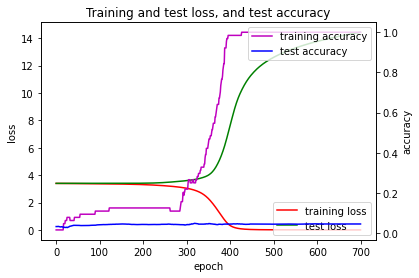

In [6]:
resultspath_singlebatch = root+'/resultsnew/cnn_singlebatch.pt'
data = torch.load(resultspath_singlebatch)
statsrec = data["stats"]

fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("mod.svg")
plt.show()



## 1.2 Training on complete dataset [23 marks]

### 1.2.1 Train CNN and show loss graph [6 marks]

Train your model on the complete training dataset, and use the validation set to determine when to stop training.

Display the graph of training and validation loss over epochs to show how you determined the optimal number of training epochs.

> As in previous sections, please leave the graph clearly displayed.


In [58]:
%%time
# TO COMPLETE
#nepochs = 300
nepochs = 300
epochs_stop = 10
improve = 0

earlystop=False

resultspath_fulldataset = root+'/resultsnew/cnn_fulldataset.pt'
statsrec = np.zeros((4,nepochs))
lossfunction = nn.CrossEntropyLoss()

optimizer = optim.SGD(cnn_v1.parameters(), lr=0.001, momentum=0.9)
minimumvalloss=np.Inf

for epoch in range(nepochs):  
    crct = 0         
    total = 0            
    runningloss = 0.0   
    n = 0                
    for data in tqdm(training_loader):
        image_s, label_s = data
        images, labels = image_s.to(device), label_s.to(device)
        
        optimizer.zero_grad()
        out_puts = cnn_v1(images)
        
        loss = lossfunction(out_puts, labels)
        loss.backward()
        optimizer.step()
        
        
        runningloss += loss.item()
        n += 1
        
        
        _, predicted = torch.max(out_puts.data, 1)
        total += labels.size(0)   
        crct += (predicted == labels).sum().item() 
        
        
    ltrn = runningloss/n
    atrn = crct/total 
    ltst, atst = stats(validation_loader, cnn_v1)
    if ltst<minimumvalloss:
        epochs_no_improve = 0
        minimumvalloss = ltst
    else:
        epochs_no_improve+=1
        
    if epoch > 5 and epochs_no_improve == epochs_stop:
        print('Early stopping!' )
        earlystop = True
        break
    statsrec[:,epoch] = (ltrn,atrn, ltst.cpu(), atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

torch.save({"state_dict": cnn_v1.state_dict(), "stats": statsrec}, resultspath_fulldataset)



100%|██████████| 148/148 [00:05<00:00, 25.76it/s]


epoch: 0 training loss:  3.806 training accuracy:  4.4%  test loss:  3.361 test accuracy:  5.3%


100%|██████████| 148/148 [00:05<00:00, 26.31it/s]


epoch: 1 training loss:  3.327 training accuracy:  6.8%  test loss:  3.315 test accuracy:  6.6%


100%|██████████| 148/148 [00:04<00:00, 29.61it/s]


epoch: 2 training loss:  3.281 training accuracy:  7.8%  test loss:  3.286 test accuracy:  8.0%


100%|██████████| 148/148 [00:05<00:00, 26.39it/s]


epoch: 3 training loss:  3.252 training accuracy:  8.6%  test loss:  3.274 test accuracy:  8.2%


100%|██████████| 148/148 [00:05<00:00, 27.55it/s]


epoch: 4 training loss:  3.230 training accuracy:  10.0%  test loss:  3.267 test accuracy:  8.3%


100%|██████████| 148/148 [00:05<00:00, 29.54it/s]


epoch: 5 training loss:  3.207 training accuracy:  10.1%  test loss:  3.249 test accuracy:  9.1%


100%|██████████| 148/148 [00:05<00:00, 26.07it/s]


epoch: 6 training loss:  3.186 training accuracy:  10.9%  test loss:  3.221 test accuracy:  9.6%


100%|██████████| 148/148 [00:05<00:00, 26.29it/s]


epoch: 7 training loss:  3.161 training accuracy:  12.2%  test loss:  3.212 test accuracy:  10.4%


100%|██████████| 148/148 [00:05<00:00, 26.09it/s]


epoch: 8 training loss:  3.134 training accuracy:  13.2%  test loss:  3.194 test accuracy:  10.7%


100%|██████████| 148/148 [00:05<00:00, 27.66it/s]


epoch: 9 training loss:  3.102 training accuracy:  13.9%  test loss:  3.154 test accuracy:  12.0%


100%|██████████| 148/148 [00:05<00:00, 26.26it/s]


epoch: 10 training loss:  3.057 training accuracy:  14.8%  test loss:  3.110 test accuracy:  13.1%


100%|██████████| 148/148 [00:05<00:00, 26.05it/s]


epoch: 11 training loss:  2.993 training accuracy:  15.9%  test loss:  3.066 test accuracy:  14.3%


100%|██████████| 148/148 [00:05<00:00, 28.79it/s]


epoch: 12 training loss:  2.956 training accuracy:  16.6%  test loss:  3.055 test accuracy:  14.2%


100%|██████████| 148/148 [00:05<00:00, 29.07it/s]


epoch: 13 training loss:  2.936 training accuracy:  17.0%  test loss:  3.056 test accuracy:  13.8%


100%|██████████| 148/148 [00:04<00:00, 30.15it/s]


epoch: 14 training loss:  2.904 training accuracy:  17.6%  test loss:  3.010 test accuracy:  15.9%


100%|██████████| 148/148 [00:05<00:00, 29.38it/s]


epoch: 15 training loss:  2.877 training accuracy:  18.2%  test loss:  3.004 test accuracy:  15.4%


100%|██████████| 148/148 [00:05<00:00, 26.37it/s]


epoch: 16 training loss:  2.854 training accuracy:  19.0%  test loss:  2.983 test accuracy:  15.2%


100%|██████████| 148/148 [00:05<00:00, 26.27it/s]


epoch: 17 training loss:  2.826 training accuracy:  19.4%  test loss:  2.987 test accuracy:  16.3%


100%|██████████| 148/148 [00:04<00:00, 30.88it/s]


epoch: 18 training loss:  2.796 training accuracy:  20.4%  test loss:  2.938 test accuracy:  17.2%


100%|██████████| 148/148 [00:05<00:00, 29.16it/s]


epoch: 19 training loss:  2.764 training accuracy:  21.2%  test loss:  2.898 test accuracy:  18.9%


100%|██████████| 148/148 [00:05<00:00, 26.02it/s]


epoch: 20 training loss:  2.725 training accuracy:  22.7%  test loss:  2.893 test accuracy:  17.6%


100%|██████████| 148/148 [00:04<00:00, 30.51it/s]


epoch: 21 training loss:  2.684 training accuracy:  23.6%  test loss:  2.862 test accuracy:  19.3%


100%|██████████| 148/148 [00:05<00:00, 25.93it/s]


epoch: 22 training loss:  2.640 training accuracy:  24.7%  test loss:  2.826 test accuracy:  20.1%


100%|██████████| 148/148 [00:05<00:00, 26.16it/s]


epoch: 23 training loss:  2.601 training accuracy:  26.3%  test loss:  2.817 test accuracy:  19.8%


100%|██████████| 148/148 [00:05<00:00, 26.29it/s]


epoch: 24 training loss:  2.555 training accuracy:  27.0%  test loss:  2.765 test accuracy:  21.7%


100%|██████████| 148/148 [00:05<00:00, 26.19it/s]


epoch: 25 training loss:  2.506 training accuracy:  28.5%  test loss:  2.721 test accuracy:  22.8%


100%|██████████| 148/148 [00:05<00:00, 26.03it/s]


epoch: 26 training loss:  2.477 training accuracy:  28.6%  test loss:  2.820 test accuracy:  20.9%


100%|██████████| 148/148 [00:05<00:00, 26.10it/s]


epoch: 27 training loss:  2.438 training accuracy:  29.8%  test loss:  2.700 test accuracy:  24.2%


100%|██████████| 148/148 [00:05<00:00, 26.13it/s]


epoch: 28 training loss:  2.387 training accuracy:  31.4%  test loss:  2.683 test accuracy:  23.4%


100%|██████████| 148/148 [00:05<00:00, 26.25it/s]


epoch: 29 training loss:  2.371 training accuracy:  31.8%  test loss:  2.619 test accuracy:  25.3%


100%|██████████| 148/148 [00:05<00:00, 26.04it/s]


epoch: 30 training loss:  2.319 training accuracy:  33.0%  test loss:  2.618 test accuracy:  25.4%


100%|██████████| 148/148 [00:05<00:00, 26.18it/s]


epoch: 31 training loss:  2.293 training accuracy:  33.6%  test loss:  2.612 test accuracy:  25.3%


100%|██████████| 148/148 [00:05<00:00, 26.10it/s]


epoch: 32 training loss:  2.242 training accuracy:  35.6%  test loss:  2.587 test accuracy:  26.9%


100%|██████████| 148/148 [00:05<00:00, 26.00it/s]


epoch: 33 training loss:  2.215 training accuracy:  36.4%  test loss:  2.603 test accuracy:  27.1%


100%|██████████| 148/148 [00:05<00:00, 26.12it/s]


epoch: 34 training loss:  2.178 training accuracy:  37.2%  test loss:  2.597 test accuracy:  26.7%


100%|██████████| 148/148 [00:05<00:00, 26.68it/s]


epoch: 35 training loss:  2.147 training accuracy:  37.4%  test loss:  2.588 test accuracy:  26.9%


100%|██████████| 148/148 [00:05<00:00, 25.98it/s]


epoch: 36 training loss:  2.100 training accuracy:  39.5%  test loss:  2.573 test accuracy:  27.3%


100%|██████████| 148/148 [00:05<00:00, 25.90it/s]


epoch: 37 training loss:  2.062 training accuracy:  40.6%  test loss:  2.606 test accuracy:  27.7%


100%|██████████| 148/148 [00:05<00:00, 26.13it/s]


epoch: 38 training loss:  2.040 training accuracy:  41.1%  test loss:  2.642 test accuracy:  26.2%


100%|██████████| 148/148 [00:05<00:00, 26.22it/s]


epoch: 39 training loss:  2.003 training accuracy:  42.8%  test loss:  2.544 test accuracy:  28.9%


100%|██████████| 148/148 [00:05<00:00, 26.17it/s]


epoch: 40 training loss:  1.945 training accuracy:  43.9%  test loss:  2.532 test accuracy:  29.6%


100%|██████████| 148/148 [00:05<00:00, 25.98it/s]


epoch: 41 training loss:  1.919 training accuracy:  45.1%  test loss:  2.573 test accuracy:  29.4%


100%|██████████| 148/148 [00:05<00:00, 26.04it/s]


epoch: 42 training loss:  1.876 training accuracy:  46.1%  test loss:  2.554 test accuracy:  29.9%


100%|██████████| 148/148 [00:05<00:00, 25.97it/s]


epoch: 43 training loss:  1.828 training accuracy:  46.8%  test loss:  2.631 test accuracy:  28.3%


100%|██████████| 148/148 [00:05<00:00, 26.16it/s]


epoch: 44 training loss:  1.796 training accuracy:  47.9%  test loss:  2.542 test accuracy:  30.8%


100%|██████████| 148/148 [00:05<00:00, 26.19it/s]


epoch: 45 training loss:  1.754 training accuracy:  49.0%  test loss:  2.575 test accuracy:  29.9%


100%|██████████| 148/148 [00:05<00:00, 26.03it/s]


epoch: 46 training loss:  1.722 training accuracy:  49.4%  test loss:  2.583 test accuracy:  30.2%


100%|██████████| 148/148 [00:05<00:00, 26.19it/s]


epoch: 47 training loss:  1.681 training accuracy:  50.5%  test loss:  2.618 test accuracy:  29.2%


100%|██████████| 148/148 [00:05<00:00, 26.29it/s]


epoch: 48 training loss:  1.612 training accuracy:  52.8%  test loss:  2.665 test accuracy:  29.5%


100%|██████████| 148/148 [00:05<00:00, 26.01it/s]


epoch: 49 training loss:  1.600 training accuracy:  52.7%  test loss:  2.674 test accuracy:  30.1%


100%|██████████| 148/148 [00:05<00:00, 26.39it/s]


Early stopping!
Wall time: 6min 26s


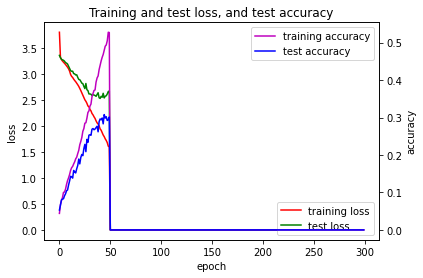

In [7]:
resultspath_fulldataset = root+'/resultsnew/cnn_fulldataset.pt'
data = torch.load(resultspath_fulldataset)
statsrec = data["stats"]
fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("mod1.svg")
plt.show()


### 1.2.2 Finetuning [6 marks]

Now finetune your architecture by implementing at least 2 methods of reducing overfitting and increasing the model's ability to generalise. You are encouraged to further adjust the model after you have done the minimum requirement, to increase your model performance. Please do not use any pre-trained weights from a model trained on ImageNet.


**Method 1:** Data augmentation of your choice

**Method 2:** Adding dropout and/or batch normalisation to the model

If you adjust the Model class, redefine it below and instantiate it as ```model_122a```, ```model_122b```, and so on.



In [8]:
transform = transforms.Compose([                        
   transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5]),
])

dataset = ImageFolder(root+'/train_set/train_set',transform=transform)
print(dataset)
print(len(dataset.classes))
training_loader= int(0.80 * len(dataset))
validation_size = len(dataset) - training_size
training_dataset, validation_dataset = torch.utils.data.random_split(dataset, [training_size, validation_size])
training_loader = torch.utils.data.DataLoader(training_dataset,batch_size=64, shuffle=True,num_workers=2)
validation_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=64, shuffle=True,num_workers=2)


Dataset ImageFolder
    Number of datapoints: 13500
    Root location: ./data/train_set/train_set
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.05)
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
30


In [9]:
# Adding drop out
model_122a = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=50, kernel_size=3,padding=1),  
    nn.ReLU(inplace=True), 
    nn.Conv2d(in_channels=50,out_channels=75,  kernel_size=3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.5),  
    nn.Conv2d(in_channels=75,out_channels=125,  kernel_size=3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=125,out_channels=256,  kernel_size=3,padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(p=0.25),
    nn.Flatten(),
    nn.Linear(256*8*8,1000), 
    nn.Dropout(p=0.25),  
    nn.Linear(1000,500),
    nn.Dropout(p=0.25),  
    nn.Linear(500,200),
    nn.Dropout(p=0.5),
    nn.Linear(200,30)
)

cnn_v2 = model_122a.to(device)

for param in cnn_v2.parameters():
    print(param.shape)

torch.Size([50, 3, 3, 3])
torch.Size([50])
torch.Size([75, 50, 3, 3])
torch.Size([75])
torch.Size([125, 75, 3, 3])
torch.Size([125])
torch.Size([256, 125, 3, 3])
torch.Size([256])
torch.Size([1000, 16384])
torch.Size([1000])
torch.Size([500, 1000])
torch.Size([500])
torch.Size([200, 500])
torch.Size([200])
torch.Size([30, 200])
torch.Size([30])


In [10]:
def stats1(loader, cnn_v2):
    crct = 0
    total = 0
    runningloss = 0
    n = 0    
    with torch.no_grad():
        for data in loader:
            image_s, label_s = data
            images, labels = image_s.to(device), label_s.to(device)
            
            out_puts = cnn_v2(images)      
            runningloss += lossfunction(out_puts, labels)
            n += 1
            _, predicted = torch.max(out_puts.data, 1)
            total += labels.size(0)    
            crct += (predicted == labels).sum().item() 
            
    return runningloss/n, crct/total 

In [63]:
%%time
nepochs = 100

resultspath_finetuned = root+'/resultsnew/cnn_finetuned.pt'
statsrec = np.zeros((4,nepochs))
lossfunction = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(cnn_v2.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience = 5)
minimumvalloss=np.Inf
for epoch in range(nepochs): 
    crct = 0          
    total = 0            
    runningloss = 0.0   
    n = 0
    for data in tqdm(training_loader):
        image_s, label_s = data
        images, labels = image_s.to(device), label_s.to(device)
        
        optimizer2.zero_grad()
        
        out_puts = cnn_v2(images)
        loss = lossfunction(out_puts, labels)
        loss.backward()
        optimizer.step()
        runningloss += loss.item()
        n += 1
        _, predicted = torch.max(out_puts.data, 1)
        total += labels.size(0)   
        crct += (predicted == labels).sum().item() 
    ltrn = runningloss/n
    atrn = crct/total 
    ltst, atst = stats1(validation_loader, cnn_v2)
    scheduler.step(ltst/len(validation_loader))
    statsrec[:,epoch] = (ltrn, atrn, ltst.cpu(), atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f} training accuracy: {atrn: .1%}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

torch.save({"state_dict": cnn_v2.state_dict(), "stats": statsrec}, resultspath_finetuned)



100%|██████████| 148/148 [00:07<00:00, 19.19it/s]


epoch: 0 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  3.0%


100%|██████████| 148/148 [00:07<00:00, 19.71it/s]


epoch: 1 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  3.4%


100%|██████████| 148/148 [00:07<00:00, 18.55it/s]


epoch: 2 training loss:  3.402 training accuracy:  3.6%  test loss:  3.403 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 19.74it/s]


epoch: 3 training loss:  3.402 training accuracy:  3.4%  test loss:  3.404 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.64it/s]


epoch: 4 training loss:  3.402 training accuracy:  3.5%  test loss:  3.403 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.72it/s]


epoch: 5 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  2.6%


100%|██████████| 148/148 [00:07<00:00, 19.73it/s]


epoch: 6 training loss:  3.403 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.6%


100%|██████████| 148/148 [00:07<00:00, 19.70it/s]


epoch: 7 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.1%


100%|██████████| 148/148 [00:07<00:00, 19.53it/s]


epoch: 8 training loss:  3.402 training accuracy:  3.4%  test loss:  3.402 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 18.54it/s]


epoch: 9 training loss:  3.402 training accuracy:  3.4%  test loss:  3.403 test accuracy:  3.1%


100%|██████████| 148/148 [00:07<00:00, 19.54it/s]


epoch: 10 training loss:  3.403 training accuracy:  3.1%  test loss:  3.404 test accuracy:  3.6%


100%|██████████| 148/148 [00:07<00:00, 19.72it/s]


epoch: 11 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  3.1%


100%|██████████| 148/148 [00:08<00:00, 17.69it/s]


epoch: 12 training loss:  3.403 training accuracy:  3.0%  test loss:  3.403 test accuracy:  2.8%


100%|██████████| 148/148 [00:07<00:00, 18.97it/s]


epoch: 13 training loss:  3.402 training accuracy:  3.4%  test loss:  3.404 test accuracy:  2.5%


100%|██████████| 148/148 [00:07<00:00, 18.51it/s]


epoch: 14 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 19.60it/s]


epoch: 15 training loss:  3.402 training accuracy:  3.0%  test loss:  3.403 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.61it/s]


epoch: 16 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.5%


100%|██████████| 148/148 [00:07<00:00, 19.78it/s]


epoch: 17 training loss:  3.402 training accuracy:  3.1%  test loss:  3.403 test accuracy:  3.0%


100%|██████████| 148/148 [00:07<00:00, 19.20it/s]


epoch: 18 training loss:  3.402 training accuracy:  3.2%  test loss:  3.404 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 19.53it/s]


epoch: 19 training loss:  3.403 training accuracy:  3.2%  test loss:  3.403 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.67it/s]


epoch: 20 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  3.0%


100%|██████████| 148/148 [00:07<00:00, 19.68it/s]


epoch: 21 training loss:  3.403 training accuracy:  3.4%  test loss:  3.402 test accuracy:  3.5%


100%|██████████| 148/148 [00:07<00:00, 19.56it/s]


epoch: 22 training loss:  3.403 training accuracy:  3.5%  test loss:  3.403 test accuracy:  3.4%


100%|██████████| 148/148 [00:07<00:00, 19.61it/s]


epoch: 23 training loss:  3.402 training accuracy:  3.4%  test loss:  3.403 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.68it/s]


epoch: 24 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.75it/s]


epoch: 25 training loss:  3.402 training accuracy:  3.5%  test loss:  3.403 test accuracy:  3.8%


100%|██████████| 148/148 [00:07<00:00, 19.55it/s]


epoch: 26 training loss:  3.402 training accuracy:  3.3%  test loss:  3.404 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 18.90it/s]


epoch: 27 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  3.4%


100%|██████████| 148/148 [00:07<00:00, 19.59it/s]


epoch: 28 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.1%


100%|██████████| 148/148 [00:07<00:00, 19.57it/s]


epoch: 29 training loss:  3.403 training accuracy:  3.4%  test loss:  3.403 test accuracy:  3.0%


100%|██████████| 148/148 [00:07<00:00, 19.29it/s]


epoch: 30 training loss:  3.403 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.7%


100%|██████████| 148/148 [00:08<00:00, 18.49it/s]


epoch: 31 training loss:  3.402 training accuracy:  3.1%  test loss:  3.403 test accuracy:  3.1%


100%|██████████| 148/148 [00:07<00:00, 18.53it/s]


epoch: 32 training loss:  3.403 training accuracy:  3.2%  test loss:  3.403 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.60it/s]


epoch: 33 training loss:  3.403 training accuracy:  3.1%  test loss:  3.403 test accuracy:  3.4%


100%|██████████| 148/148 [00:07<00:00, 19.67it/s]


epoch: 34 training loss:  3.402 training accuracy:  3.3%  test loss:  3.404 test accuracy:  2.7%


100%|██████████| 148/148 [00:07<00:00, 19.73it/s]


epoch: 35 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.57it/s]


epoch: 36 training loss:  3.402 training accuracy:  3.1%  test loss:  3.403 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.62it/s]


epoch: 37 training loss:  3.403 training accuracy:  3.3%  test loss:  3.403 test accuracy:  3.4%


100%|██████████| 148/148 [00:07<00:00, 19.53it/s]


epoch: 38 training loss:  3.403 training accuracy:  3.1%  test loss:  3.403 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.64it/s]


epoch: 39 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.0%


100%|██████████| 148/148 [00:07<00:00, 19.45it/s]


epoch: 40 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.67it/s]


epoch: 41 training loss:  3.402 training accuracy:  3.1%  test loss:  3.403 test accuracy:  2.6%


100%|██████████| 148/148 [00:07<00:00, 19.53it/s]


epoch: 42 training loss:  3.403 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.0%


100%|██████████| 148/148 [00:07<00:00, 19.63it/s]


epoch: 43 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.80it/s]


epoch: 44 training loss:  3.402 training accuracy:  3.4%  test loss:  3.403 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.49it/s]


epoch: 45 training loss:  3.402 training accuracy:  3.4%  test loss:  3.403 test accuracy:  3.0%


100%|██████████| 148/148 [00:07<00:00, 19.59it/s]


epoch: 46 training loss:  3.402 training accuracy:  3.4%  test loss:  3.404 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.69it/s]


epoch: 47 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.80it/s]


epoch: 48 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.74it/s]


epoch: 49 training loss:  3.402 training accuracy:  3.3%  test loss:  3.402 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.79it/s]


epoch: 50 training loss:  3.402 training accuracy:  3.6%  test loss:  3.404 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 19.65it/s]


epoch: 51 training loss:  3.402 training accuracy:  3.1%  test loss:  3.403 test accuracy:  3.6%


100%|██████████| 148/148 [00:07<00:00, 19.67it/s]


epoch: 52 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  3.1%


100%|██████████| 148/148 [00:07<00:00, 19.62it/s]


epoch: 53 training loss:  3.403 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.60it/s]


epoch: 54 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.1%


100%|██████████| 148/148 [00:07<00:00, 19.58it/s]


epoch: 55 training loss:  3.403 training accuracy:  3.0%  test loss:  3.404 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 19.60it/s]


epoch: 56 training loss:  3.402 training accuracy:  3.5%  test loss:  3.403 test accuracy:  2.8%


100%|██████████| 148/148 [00:07<00:00, 19.69it/s]


epoch: 57 training loss:  3.402 training accuracy:  3.2%  test loss:  3.404 test accuracy:  3.6%


100%|██████████| 148/148 [00:07<00:00, 19.56it/s]


epoch: 58 training loss:  3.403 training accuracy:  3.1%  test loss:  3.402 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.61it/s]


epoch: 59 training loss:  3.402 training accuracy:  3.5%  test loss:  3.403 test accuracy:  3.6%


100%|██████████| 148/148 [00:07<00:00, 19.74it/s]


epoch: 60 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.8%


100%|██████████| 148/148 [00:07<00:00, 19.40it/s]


epoch: 61 training loss:  3.403 training accuracy:  3.5%  test loss:  3.403 test accuracy:  3.5%


100%|██████████| 148/148 [00:07<00:00, 19.78it/s]


epoch: 62 training loss:  3.402 training accuracy:  3.6%  test loss:  3.403 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 19.50it/s]


epoch: 63 training loss:  3.402 training accuracy:  3.7%  test loss:  3.403 test accuracy:  3.5%


100%|██████████| 148/148 [00:07<00:00, 19.60it/s]


epoch: 64 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.78it/s]


epoch: 65 training loss:  3.402 training accuracy:  3.4%  test loss:  3.403 test accuracy:  3.4%


100%|██████████| 148/148 [00:07<00:00, 19.54it/s]


epoch: 66 training loss:  3.402 training accuracy:  3.6%  test loss:  3.404 test accuracy:  3.1%


100%|██████████| 148/148 [00:07<00:00, 19.62it/s]


epoch: 67 training loss:  3.402 training accuracy:  3.3%  test loss:  3.404 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.76it/s]


epoch: 68 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.4%


100%|██████████| 148/148 [00:07<00:00, 19.57it/s]


epoch: 69 training loss:  3.402 training accuracy:  3.5%  test loss:  3.404 test accuracy:  3.0%


100%|██████████| 148/148 [00:07<00:00, 19.60it/s]


epoch: 70 training loss:  3.403 training accuracy:  3.4%  test loss:  3.403 test accuracy:  2.7%


100%|██████████| 148/148 [00:07<00:00, 19.51it/s]


epoch: 71 training loss:  3.402 training accuracy:  3.4%  test loss:  3.403 test accuracy:  3.7%


100%|██████████| 148/148 [00:07<00:00, 19.64it/s]


epoch: 72 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  2.7%


100%|██████████| 148/148 [00:07<00:00, 19.53it/s]


epoch: 73 training loss:  3.402 training accuracy:  3.8%  test loss:  3.403 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 19.62it/s]


epoch: 74 training loss:  3.403 training accuracy:  3.2%  test loss:  3.404 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.52it/s]


epoch: 75 training loss:  3.403 training accuracy:  3.3%  test loss:  3.403 test accuracy:  2.6%


100%|██████████| 148/148 [00:07<00:00, 19.64it/s]


epoch: 76 training loss:  3.402 training accuracy:  3.2%  test loss:  3.402 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.46it/s]


epoch: 77 training loss:  3.403 training accuracy:  3.8%  test loss:  3.403 test accuracy:  3.8%


100%|██████████| 148/148 [00:07<00:00, 19.56it/s]


epoch: 78 training loss:  3.402 training accuracy:  3.1%  test loss:  3.403 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.77it/s]


epoch: 79 training loss:  3.403 training accuracy:  3.1%  test loss:  3.403 test accuracy:  3.0%


100%|██████████| 148/148 [00:07<00:00, 19.59it/s]


epoch: 80 training loss:  3.402 training accuracy:  3.4%  test loss:  3.404 test accuracy:  3.4%


100%|██████████| 148/148 [00:07<00:00, 19.61it/s]


epoch: 81 training loss:  3.403 training accuracy:  3.4%  test loss:  3.403 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.46it/s]


epoch: 82 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  3.0%


100%|██████████| 148/148 [00:07<00:00, 19.68it/s]


epoch: 83 training loss:  3.402 training accuracy:  3.3%  test loss:  3.403 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.75it/s]


epoch: 84 training loss:  3.402 training accuracy:  3.4%  test loss:  3.403 test accuracy:  2.8%


100%|██████████| 148/148 [00:07<00:00, 19.74it/s]


epoch: 85 training loss:  3.402 training accuracy:  3.5%  test loss:  3.403 test accuracy:  3.8%


100%|██████████| 148/148 [00:07<00:00, 19.79it/s]


epoch: 86 training loss:  3.403 training accuracy:  3.2%  test loss:  3.404 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 19.57it/s]


epoch: 87 training loss:  3.402 training accuracy:  3.0%  test loss:  3.403 test accuracy:  3.3%


100%|██████████| 148/148 [00:07<00:00, 19.65it/s]


epoch: 88 training loss:  3.403 training accuracy:  3.7%  test loss:  3.403 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.73it/s]


epoch: 89 training loss:  3.403 training accuracy:  3.4%  test loss:  3.403 test accuracy:  3.1%


100%|██████████| 148/148 [00:07<00:00, 19.54it/s]


epoch: 90 training loss:  3.402 training accuracy:  3.5%  test loss:  3.403 test accuracy:  3.5%


100%|██████████| 148/148 [00:07<00:00, 19.66it/s]


epoch: 91 training loss:  3.402 training accuracy:  3.6%  test loss:  3.403 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 19.51it/s]


epoch: 92 training loss:  3.402 training accuracy:  3.4%  test loss:  3.403 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 19.53it/s]


epoch: 93 training loss:  3.402 training accuracy:  3.2%  test loss:  3.403 test accuracy:  3.2%


100%|██████████| 148/148 [00:07<00:00, 19.56it/s]


epoch: 94 training loss:  3.402 training accuracy:  3.6%  test loss:  3.403 test accuracy:  3.1%


100%|██████████| 148/148 [00:07<00:00, 19.58it/s]


epoch: 95 training loss:  3.403 training accuracy:  3.3%  test loss:  3.404 test accuracy:  2.8%


100%|██████████| 148/148 [00:07<00:00, 19.72it/s]


epoch: 96 training loss:  3.403 training accuracy:  3.5%  test loss:  3.403 test accuracy:  2.9%


100%|██████████| 148/148 [00:07<00:00, 19.53it/s]


epoch: 97 training loss:  3.403 training accuracy:  3.1%  test loss:  3.403 test accuracy:  3.0%


100%|██████████| 148/148 [00:07<00:00, 19.70it/s]


epoch: 98 training loss:  3.402 training accuracy:  3.0%  test loss:  3.403 test accuracy:  3.0%


100%|██████████| 148/148 [00:07<00:00, 19.48it/s]


epoch: 99 training loss:  3.402 training accuracy:  3.5%  test loss:  3.403 test accuracy:  2.9%
Wall time: 19min 21s


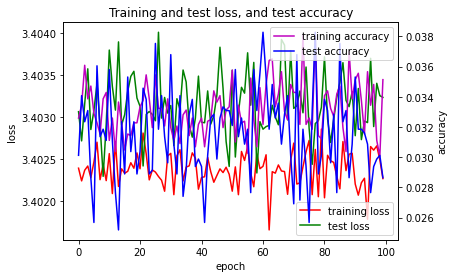

In [11]:
resultspath_finetuned = root+'/resultsnew/cnn_finetuned.pt'
data = torch.load(resultspath_finetuned)
statsrec = data["stats"]

fig, ax1 = plt.subplots()
plt.plot(statsrec[0], 'r', label = 'training loss', )
plt.plot(statsrec[2], 'g', label = 'test loss' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2=ax1.twinx()
ax2.plot(statsrec[1], 'm', label = 'training accuracy')
ax2.plot(statsrec[3], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc='upper right')
fig.savefig("mod1.svg")
plt.show()


### 1.2.3 Training comparison [4 marks]

Display, side-by-side or on one single graph, the training and validation loss graphs for the single-batch training (section 1.1.3), on the full training set (1.2.1) and your final fine-tuned model (1.2.2). 

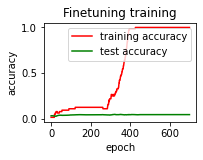

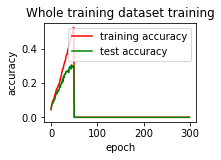

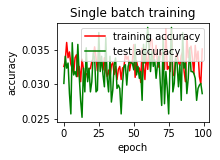

In [65]:
ax = plt.subplot(2,2,1)
data = torch.load(resultspath_singlebatch)
statsrec = data["stats"]
plt.plot(statsrec[1], 'r', label =  'training accuracy', )
plt.plot(statsrec[3], 'g', label =  'test accuracy' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Single batch training')
plt.legend(loc='upper right')
plt.show()


ax = plt.subplot(2,2,1)

data = torch.load(resultspath_fulldataset)
statsrec = data["stats"]
plt.plot(statsrec[1], 'r', label =  'training accuracy', )
plt.plot(statsrec[3], 'g', label =  'test accuracy' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Whole training dataset training')
plt.legend(loc='upper right')
plt.show()

ax = plt.subplot(2,2,1)

data = torch.load(resultspath_finetuned)
statsrec = data["stats"]
plt.plot(statsrec[1], 'r', label =  'training accuracy', )
plt.plot(statsrec[3], 'g', label =  'test accuracy' )
plt.legend(loc='lower right')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Finetuning training')

plt.legend(loc='upper right')
plt.show()


When model is trained for single batch, its accuracy increases exponentially.

While model is trained on whole data set, the model reaches full accuracy in minimal epochs but then falls to zero after wards.

For the finetuning graph , we can see in both the cases, there was a sharp increase together which may lead to overfitting.



### 1.2.4 Confusion matrices [7 marks]

Use your architecture with best accuracy to generate two confusion matrices, one for the training set and one for the validation set. Remember to use the whole validation and training sets, and to include all your relevant code. Display the confusion matrices in a meaningful way which clearly indicates what percentage of the data is represented in each position.



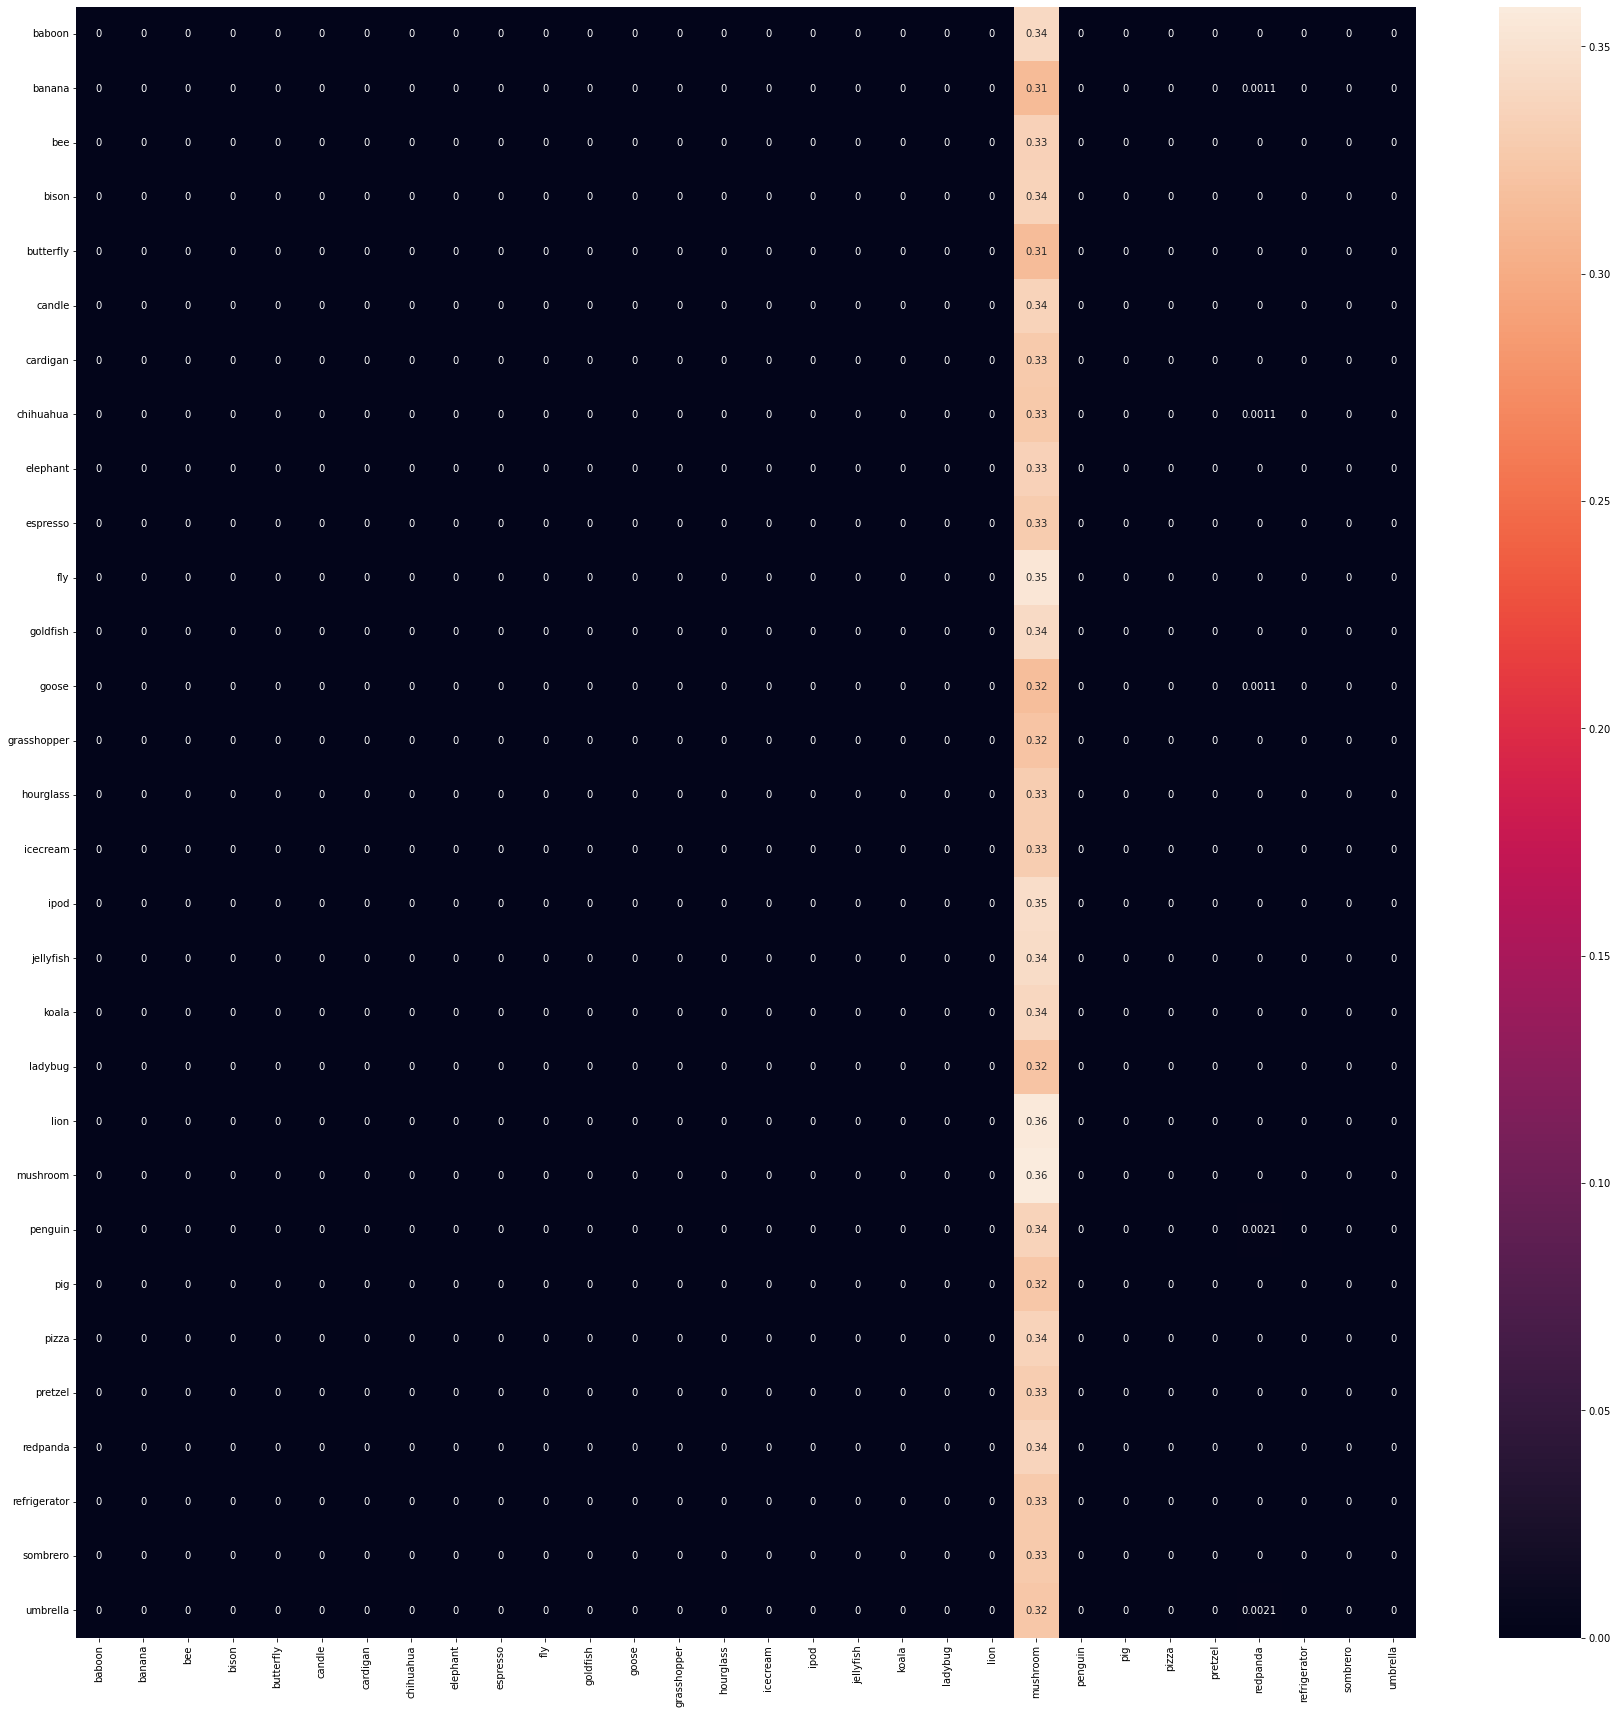

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

data=torch.load(resultspath_finetuned)
cnn_v2.load_state_dict(data["state_dict"])
cnn_v2.eval()
y_pred = []
y_true = []
class_list=[]
for key in dataset.class_to_idx.keys():
    class_list.append(key)
# iterate over test data
for data in training_loader:
    
    input_s, label_s = data
    inputs, labels = input_s.to(device), label_s.to(device)
    output = cnn_v2(inputs) # Feed Network
    # _, predicted = torch.max(outputs.data, 1)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    
   # output = predicted.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    #labels = labels.data.numpy()
    y_true.extend(labels) # Save Truth


# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in class_list],
                     columns = [i for i in class_list])
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True)
plt.savefig('confusionmatrix_output.png')

What conclusions can be drawn from the confusion matrices?



## 1.3 Testing on test data [18 marks]

### 1.3.1 Dataset and generating predictions [6 marks]

Create a PyTorch ```Dataset``` for the unlabeled test data in the test_set folder of the Kaggle competition and generate predictions using your final model. 


In [13]:
results = []

with torch.no_grad():
    for data in validation_loader:
        input_s, label_s = data
        inputs, labels = input_s.to(device), label_s.to(device)

    outputs = cnn_v2(inputs)
    results.extend(outputs.argmax(dim=1).type(torch.int32).cpu().numpy())


### 1.3.2 CSV file and test set accuracy [12 marks]

Save all test predictions to a CSV file and submit it to the private class Kaggle competition. **Please save your test CSV file submissions using your student username (the one with letters, ie., ``sc15jb``, not the ID with only numbers)**, for example, `sc15jb.csv`. That will help us to identify your submissions.

The CSV file must contain only two columns: ‘Id’ and ‘Category’ (predicted class ID) as shown below:

```txt
Id,Category
28d0f5e9_373c.JPEG,2
bbe4895f_40bf.JPEG,18
```

The ‘Id’ column should include the name of the image. It is important to keep the same name as the one on the test set. Do not include any path, just the name of file (with extension). Your csv file must contain 1501 rows, one for each image on test set and 1 row for the headers.

> You may submit multiple times. We will use your personal top entry for allocating marks for this [10 marks]. The class leaderboard will not affect marking (brownie points!).



In [23]:
names = []

In [24]:
folder_names = validation_dataset.imgs

for path in folder_names:
    names.append(path[0].split('/')[-1])
names[0:10]

AttributeError: 

In [25]:
import pandas as pd
names = pd.Series(names)
results = pd.Series(results)

submittion = pd.concat([names, results], axis=1)
submittion.columns = ['Id', 'Category']
submittion

C:\Users\Ajith\AppData\Local\Temp/ipykernel_8140/4097479151.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  names = pd.Series(names)


Id  Category
0  NaN        21
1  NaN        21
2  NaN        21
3  NaN        21
4  NaN        21
5  NaN        21
6  NaN        21
7  NaN        21
8  NaN        21
9  NaN        21
10 NaN        21
11 NaN        21
12 NaN        21
13 NaN        21
14 NaN        21
15 NaN        21
16 NaN        21
17 NaN        21

In [26]:
submittion.to_csv(root+'/dataresults/sc21kj.csv', index=False)

FileNotFoundError: [Errno 2] No such file or directory: './data/dataresults/sc21kj.csv'



## QUESTION 2 [40 marks]



In this question, you will visualize the filters and feature maps of a fully-trained CNN (AlexNet) on the full ImageNet 2012 dataset.

> Please do not alter the name of the function or the number and type of its arguments and return values, otherwise the automatic grading function will not work correctly. You are welcome to import other modules (though the simplest solution only requires the ones below).


### **Overview:**
*   **2.1.1** Extract filters from model: ``fetch_filters(layer_idx, model)``
*   **2.2.1** Load test image
*   **2.2.2** Extract feature maps for given test image: ``fetch_feature_maps(image, model)``
*   **2.2.3** Display feature maps
*   **2.3.1** Generate Grad-CAM heatmaps: ``generate_heatmap(output, class_id, model, image)``
*   **2.3.2** Display heatmaps: add code to cell
*   **2.3.3** Generate heatmaps for failure analysis


### Loading a pre-trained model

Run the cell below to load an AlexNet model with pre-trained weights.

In [74]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()

Using cache found in C:\Users\Ajith/.cache\torch\hub\pytorch_vision_v0.6.0


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [75]:
model.features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU(inplace=True)
  (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [76]:
model.features[0]

Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

In [77]:
model.features[0].weight.shape

torch.Size([64, 3, 11, 11])


## 2.1 Extract and visualize the filters [6 marks]

In this section you will extract and visualize the filters from the pre-trained AlexNet.

### 2.1.1 Extract filters [4 marks]

Complete the following function ```fetch_filters``` to return all the filters from the convolutional layers at the given index in ```model.features``` (see printed model above for reference). 





> We will not test the behaviour of your function using invalid indices.



In [78]:
def fetch_filters(layer_idx, model):
    """ 
        Args:
            layer_idx (int): the index of model.features specifying which conv layer
            model (AlexNet): PyTorch AlexNet object
        Return:
            filters (Tensor):      
    """
    filters = model.features[layer_idx].weight.data.clone()
     
    return filters

In [79]:

conv_layer_idx = [0, 3, 6, 8, 10]

filters = []

for layer_idx in conv_layer_idx:
    filters.append(fetch_filters(layer_idx, model))

For your testing purposes, the following code blocks test the dimensions of the function output.

In [80]:
filters[0].shape

torch.Size([64, 3, 11, 11])

In [81]:
assert list(filters[0].shape) == [64, 3, 11, 11]



### 2.1.2 Display filters [2 marks]

The following code will visualize some of the filters from each layer. Play around with viewing filters at different depths into the network. Note that ```filters[0]``` could be viewed in colour if you prefer, whereas the subsequent layers must be viewed one channel at a time in grayscale. 



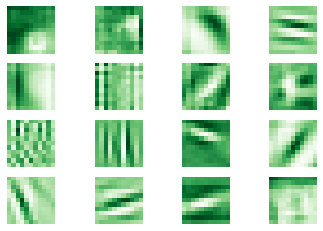

In [82]:

to_show = 16


plt_dim = int(math.sqrt(to_show))


for i, filt in enumerate(filters[0].numpy()[:to_show]):
    plt.subplot(plt_dim, plt_dim, i+1)
    plt.imshow(filt[0], cmap="Greens")
    plt.axis('off')
plt.show()



## 2.2 Extract and visualize feature maps [10 marks]

In this section, you will pass a test image through the AlexNet and extract and visualize the resulting convolutional layer feature maps.

Complete the following code cell to load the test image ```man_bike.JPEG```.



### 2.2.1 Load test image [1 mark]


In [83]:

from PIL import Image
im=Image.open(root+'/man_bike.JPEG').convert("RGB")
print(im)


<PIL.Image.Image image mode=RGB size=500x375 at 0x1456F724A00>


Run the code cell below to apply the image transformation expected by the model.

In [84]:

norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

im = data_transform(im)


### 2.2.2 Extract feature maps [5 marks]

Complete the function below to pass the test image through a single forward pass of the network. We are interested in the outputs of the max pool layers (outputs of conv layers at model.features indices 0, 3, and 10) for best visualization. Note that the input should pass through *every layer* of the model.

In [85]:
def fetch_feature_maps(image, model):
    """
    Args:
        image (Tensor): a single input image with transform applied
        model (AlexNet): PyTorch AlexNet object
        
    Return:
        feature_maps (Tensor): all the feature maps from conv layers 
                    at indices 0, 3, and 10 (outputs of the MaxPool layers)
    """
     
    
    model_weights =[]
   
    conv_layers = []
   
    all_layers=[]
    counter = 0 
    maxpool=[]
    model_children = list(model.children())

    for j in range(len(model_children[0])):
        child= model_children[0][j]
        all_layers.append(child)
        if type(child) == nn.MaxPool2d:
            
            counter += 1
 

    print(counter)
    results = [all_layers[0](image)]
  
    for i in range(1, len(all_layers)):
        
        x=all_layers[i](results[-1])
        results.append(x)
        if len(results[i][0][0]) == len(results[i-1][0][0])// 2:
            maxpool.append(x)
       
   
    maxpool=[torch.tensor(x,requires_grad=False) for x in maxpool ]
    
    return maxpool

In [86]:
feature_maps = fetch_feature_maps(im.unsqueeze(0), model)

3


C:\Users\Ajith\AppData\Local\Temp/ipykernel_16284/4082719065.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  maxpool=[torch.tensor(x,requires_grad=False) for x in maxpool ]


For your testing purposes, the following code block tests the dimensions of part of the function output. Note that the first dimension is the batch size.

In [87]:
assert len(feature_maps) == 3
assert list(feature_maps[0].shape) == [1, 64, 31, 31]



### 2.2.3 Display feature maps [4 marks]

Using the code for displaying filters as reference, write code in the block below to display the outputs of the first **16 feature maps from each of the 3 max-pool layers**.

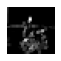

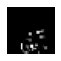

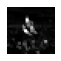

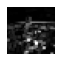

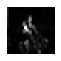

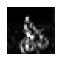

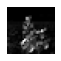

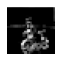

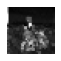

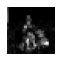

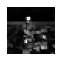

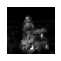

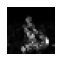

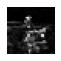

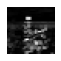

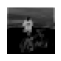

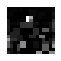

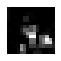

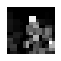

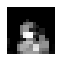

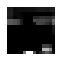

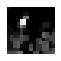

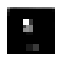

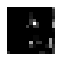

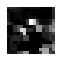

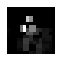

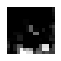

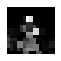

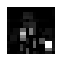

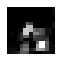

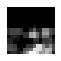

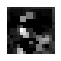

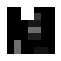

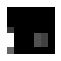

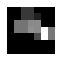

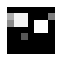

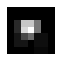

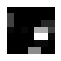

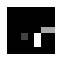

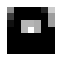

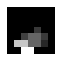

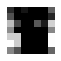

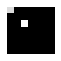

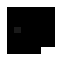

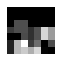

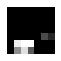

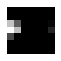

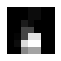

In [88]:
 # limit
n = 16

 
plt_dim = int(math.sqrt(n))


for i in range(3):
    for i, filt in enumerate(feature_maps[i][0].numpy()[:n]):
        plt.subplot(plt_dim, plt_dim, i+1)
        plt.imshow(filt, cmap="gray")
        plt.axis('off')
        plt.show()

 

 




## 2.3 Understanding of filters and feature maps [7 marks]

Respond in detail to the questions below. (Note that all text boxes can be formatted using Markdown if desired).

### 2.3.1 [3 marks]
Describe what the three filters at indices 0, 4, and 6 from the first convolutional layer are detecting (reference the corresponding feature maps to support your discussion).


--> Filter 0 -> It is classifying and grouping man and block as one element. Able to see the silhoute of the man as part of fore ground. It also detects foreground elements.

--> Filter 4 -> It detects much clearer picture of man's head and his torso.

--> Filter 6 -> Able to identify the wheels of the cycle.

### 2.3.2 [2 marks]
Discuss how the filters change with depth into the network.



--> At first, the filters detect multiple colors and edges and is able to identify different shapes.

--> At final layers, we can see more clearer image with more complex patterns that is used to identify the element in the image.

### 2.3.3 [2 marks]
Discuss how the feature maps change with depth into the network.






--> As depth increases, the image is broken down into simpler blocks.
--> At first, we will be able to see and differentiate between foreground and background scenes, but as the depth increases, it will be reduced and will be able to only see shapes that appears in the image.


## 2.4 Gradient-weighted Class Activation Mapping (Grad-CAM) [17 marks]

In this section, we will explore using Gradient-weighted Class Activation Mapping (Grad-CAM) to generate coarse localization maps highlighting the important regions in the test images guiding the model's prediction. We will continue using the pre-trained AlexNet.

#### Preparation
>It is recommended to first read the relevant paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391), and refer to relevant course material.

#### The AlexNet class

>To implement Grad-CAM, we need to edit the AlexNet ```module``` class itself, so instead of loading the AlexNet model from ```torch.hub``` as we did above, we will use the official PyTorch AlexNet class code ([taken from here](https://pytorch.org/vision/stable/_modules/torchvision/models/alexnet.html)). In addition to the class definition, there is also a function below called ```alexnet()``` which allows you to specify whether you want the pretrained version or not, and if so, loads the weights. 

#### The hook

>[Hooks](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) in PyTorch are functions which can be registered, or attached, to a ```Module``` or ```Tensor```. Hooks can be *forward* hooks or *backward* hooks; forward hooks are called with ```forward()``` and backward hooks with ```backward()```. In the model below, we register a forward hook that saves the **gradients of the activations** to the Tensor output of ```model.features```. The gradients are saved to a class variable so we can easily access them.

Carefully read the code block below. You do not need to add anything to the model.

In [89]:
model_urls = {
    'alexnet': 'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth',
}


class AlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        
        
        self.gradients = None
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        
    
    def activations_hook(self, grad):
        
        self.gradients = grad

  
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        x = self.features(x)
        
        hook = x.register_hook(self.activations_hook)
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


def alexnet(pretrained=False, progress=True, **kwargs) -> AlexNet:
    """AlexNet model architecture from the
    `"One weird trick..." <https://arxiv.org/abs/1404.5997>`_ paper.

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    model = AlexNet(**kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls['alexnet'],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model

In [90]:
model = alexnet(pretrained=True)

In [91]:

output = model(im.unsqueeze(0))
_, pred_cls = output.max(dim=1, keepdim=True)

Examine and understand the values stored in ```output``` and ```pred_cls```. What does AlexNet classify the test image as?

In [92]:
print(output.shape)
print(pred_cls)
 

torch.Size([1, 1000])
tensor([[444]])


### 2.4.1 Generate Grad-CAM heatmaps [8 marks]

With the hooks in place, now implement the code to generate Grad-CAM heatmaps, by following the guiding comments in the code block below.

In [93]:
def generate_heatmap(output, class_id, model, image):
    
    output[:,-1].backward()
    
    gradients = model.gradients
    assert list(gradients.shape) == [1, 256, 7, 7]
    
    
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    assert list(pooled_gradients.shape) == [256]
    
    
    activations = model.get_activations(image).detach()
    assert list(activations.shape) == [1, 256, 7, 7]
    
    
    for i in range(256):
        activations[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activations, dim=1).squeeze()
    assert list(heatmap.shape) == [7, 7]
    
   
    heatmap = np.maximum(heatmap, 0)

   
    heatmap /= torch.max(heatmap)

    return heatmap

In [94]:
heatmap = generate_heatmap(output, pred_cls, model, im.unsqueeze(0))

Check the dimensions of ```heatmap```. Do they make sense?

torch.Size([7, 7])

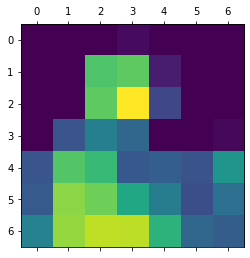

In [95]:
heatmap.shape 
plt.matshow(heatmap.squeeze())
heatmap.shape

### 2.4.2 Display heatmaps [4 marks]

Display ```heatmap``` as a coloured heatmap super-imposed onto the original image. To get results as shown in the paper, we recommend the following steps:

1. Resize the heatmap to match the size of the image.
2. Rescale the image to a 0-255 integer range.
3. Apply a colormap to the heatmap using ```cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)```.
4. Multiply all values of heatmap by 0.4 to reduce colour saturation.
5. Superimpose the heatmap onto the original image (Note: please perform cv2's addition - addition of two cv2 images, not numpy addition. See [here](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_core/py_image_arithmetics/py_image_arithmetics.html#:~:text=addWeighted()%20etc.-,Image%20Addition,OpenCV%20addition%20and%20Numpy%20addition.) for explanation.)
6. Normalize the image between 0-255 again.
7. Display the resulting image.

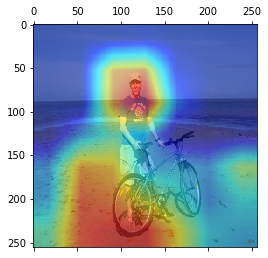

In [96]:

def display_heatmap(heatmap,image):
    (w, h) = (image.shape[0], image.shape[1])
    heatmap = cv2.resize(heatmap.numpy(), (w, h))
    
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + 1e-8
    heatmap_normalized = numer / denom
    heatmap_normalized = (heatmap_normalized * 255).astype("uint8")

    heatmap_normalized = cv2.applyColorMap(heatmap_normalized, cv2.COLORMAP_JET)
    
    heatmap_normalized=heatmap_normalized * 0.4
    
    weighted_image= cv2.addWeighted(heatmap_normalized, 0.7, image, 0.3, 0)
    
    numer = weighted_image - np.min(weighted_image)
    denom = (weighted_image.max() - weighted_image.min()) + 1e-8
    final_image = numer / denom
    final_image = (final_image * 255).astype("uint8")

    return final_image

image = cv2.imread(root+'/man_bike.JPEG')
image=cv2.resize(image,(256,256))
image = np.asarray(image, np.float64)

display=display_heatmap(heatmap,image)
plt.matshow(display[:, :, ::-1])

Show the heatmap for class ```'seashore, coast, seacoast, sea-coast'``` (```class_id = 978```), super-imposed onto the original image.

### 2.4.3 Failure analysis using Grad-CAM [5 marks]

Find an image (online, or from ImageNet or another dataset) which AlexNet classifies *incorrectly*. Display the image below, and show the model's predicted class. Then, generate the Grad-CAM heatmap and display it super-imposed onto the image.

tensor([[345]])


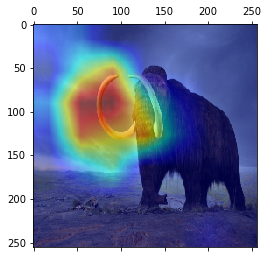

In [97]:


mammoth=Image.open(root+'/mammoth.jpg')


norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

data_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize(norm_mean, norm_std),
    ])

mammoth = data_transform(mammoth)
mod = alexnet(pretrained=True)


output = mod(mammoth.unsqueeze(0))

_, pred_cls = output.max(dim=1, keepdim=True)
print(pred_cls)
percentage = torch.nn.functional.softmax(output, dim=1)[0] * 100  
 

heatmap = generate_heatmap(output, pred_cls, mod, mammoth.unsqueeze(0))
mammoth=cv2.imread(root+'/mammoth.jpg')

mammoth=cv2.resize(mammoth,(256,256))
mammoth = np.asarray(mammoth, np.float64)
show_result = display_heatmap(heatmap, mammoth)
plt.matshow(show_result[:, :, ::-1])

Briefly describe what explanation the Grad-CAM heatmap provides about why the model has failed to correctly classify your test image.

The image that we have used is an mammoth image, but the model considers it as an ox. It may be because it has tusk similar to horns in an ox and also because of the fur.


### 3 Overall quality [2 marks]

Marks awarded for overall degree of code readibility and omission of unnecessary messy outupts (for example, please avoid printed losses for every batch of a long training process, large numpy arrays, etc.) throughout the work.

**Please refer to the submission section at the top of this notebook to prepare your submission.**
